# San Francisco Crime Classification

## Import and configuration setup


In [35]:
# Import Libraries
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

import pyspark
from pyspark.sql.functions import pandas_udf, year, month, hour, isnan, isnull, col, sum as _sum, count as _count, udf
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

In [2]:
# Setup the Configuration
conf = pyspark.SparkConf()
spark_context = SparkSession.builder.config(conf=conf).getOrCreate()

24/01/20 07:58:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In order to manage the randomness I wrote the following cell to make the experiments reproducible.

A numpy Random Generator object is constructed for controlling randomness. The seed is set to 42 for reproducibility.

In [3]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [4]:
def plot_stacked_bars(dataframe, column, label, size=(18, 10), sort_by=None):
    if sort_by not in ["column", "label", None]:
        raise ValueError("sort_by must be one of column, label or None")
    # Group by 'column' and 'label', then count the occurrences
    group_count = dataframe.groupBy(column, label).count()

    # Pivot to get a column for each 'label' with counts as values
    pivot_df = group_count.groupBy(column).pivot(label).sum('count')

    # sort by the 'column' values
    if sort_by == "column":
        frequencies = pivot_df.orderBy(column)
    elif sort_by == "label":
        # Calculate the total counts per 'column' value for sorting
        total_counts = group_count.groupBy(column).agg(_sum('count').alias('Total'))

        # Join the total counts with the pivot_df to sort by
        frequencies = pivot_df.join(total_counts, on=column).orderBy('Total', ascending=False).drop('Total')
    else:
        frequencies = pivot_df

    # Convert to Pandas DataFrame for plotting
    pandas_df = frequencies.toPandas().set_index(column)

    # Plot the stacked bar chart
    ax = pandas_df.plot(kind='bar', stacked=True, figsize=size, legend=False)
    ax.set_title(f'Stacked Bar Plot of {label} for each value of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Counts')

    # Rotate x-axis labels for better readability if there are many categories
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

def plot_label_sum_bars(dataframe, column, label, size=(18, 10), sort_by=None):
    if sort_by not in ["column", "label", None]:
        raise ValueError("sort_by must be one of column, label or None")

    # Group by 'column' and 'label', then count the occurrences
    frequencies = dataframe.groupBy(column).agg(_count(label).alias('Total'))

    # sort by the 'column' values
    if sort_by == "column":
        frequencies = frequencies.orderBy(column)
    elif sort_by == "label":
        # Join the total counts with the pivot_df to sort by
        frequencies = frequencies.orderBy('Total', ascending=False)

     # Convert to Pandas DataFrame for plotting
    pandas_df = frequencies.toPandas().set_index(column)

    # Plot the stacked bar chart
    ax = pandas_df.plot(kind='bar', stacked=True, figsize=size, legend=False)
    ax.set_title(f'Stacked Bar Plot of {label} for each value of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Counts')

    # Rotate x-axis labels for better readability if there are many categories
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

def subplots_of_columns_over_labels(dataframe, label, columns, limit_labels=6, num_cols=3, figsize=(15, 12)):
    label_categories = dataframe.select(label).groupby(label).count().orderBy('count', ascending=False).limit(limit_labels).toPandas()[label].tolist()
    
    num_categories = len(label_categories)
    num_rows = (num_categories + num_cols - 1) // num_cols  # Number of rows in the subplot grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    faxes = axes.ravel()
    fig.tight_layout(pad=7.0)

    # Iterate through each category and plot the distribution over the columns
    for i, category in enumerate(label_categories):
        # Get the data for the current category
        category_data = dataframe.filter(dataframe[label] == category).groupBy(columns).count().orderBy(columns).toPandas()

        # Plot the distribution
        ax = faxes[i]
        ax.bar(category_data[columns], category_data['count'])
        ax.set_title(category)
        ax.set_xlabel(columns)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', labelrotation=45)
        # set the minimum and maximum y values to zoom in on the data
        y_min_value = max(category_data['count'].min() - 100, 0)
        y_max_value = category_data['count'].max() + 100
        ax.set_ylim([y_min_value, y_max_value])

    # Hide empty subplots
    for i in range(num_categories, num_rows * num_cols):
        ax = faxes[i]
        ax.axis('off')

    plt.show()

def print_mean_std_dev(df, column, exclude_list=None):
    col_frequencies = df.groupBy(column).count().orderBy(column, ascending=True)
    if exclude_list is not None:
        
        col_frequencies = col_frequencies.filter(col_frequencies[column].isin(exclude_list) == False)
    # compute mean and standard deviation
    col_frequencies.agg({'count': 'mean'}).show()
    col_frequencies.agg({'count': 'stddev'}).show()

## Exploration of data

For the project I used the San Francisco Crime Classification dataset ([Kaggle link](https://www.kaggle.com/c/sf-crime/overview)).

The dataset contains information about the crimes in the San Francisco bay area and the target variable for the **multi-class** classification task is the crime that occured.

The dataset has already been split in train and test sets, however the test set is not labeled, hence won't be used. The test set will be created by splitting the training set.

In the training dataset, there are 878049 samples with 8 features. The features are a mix of numerical, categorical and text data, but some of them are redundant (Address) or not useful for our analysis (Resolution, Descript).

Moreover, some of the features are not well formatted, for example the Dates feature is a timestamp in the format YYYY-MM-DD HH:MM:SS, while the DayOfWeek feature is a string with the day of the week.

### Load and show the dataset

The dataset is loaded from the csv file stored in the HDFS filesystem.

In [5]:
df_train_raw = spark_context.read.csv('dataset/train.csv', header=True, inferSchema=True)
df_train_raw = df_train_raw.repartition(100)

df_test_raw = spark_context.read.csv('dataset/test.csv', header=True, inferSchema=True)

# Number of rows and columns
print(f"Train dataset\nRows: {df_train_raw.count()}\nColumns: {len(df_train_raw.columns)}", end="\n\n")
print(f"Test dataset\nRows: {df_test_raw.count()}\nColumns: {len(df_test_raw.columns)}")

Train dataset
Rows: 878049
Columns: 9



Test dataset
Rows: 884262
Columns: 7


In the following cell the dataset is loaded and the first 5 rows are shown.

In [6]:
df_train_raw.show(5)

+-------------------+--------------+--------------------+---------+----------+-----------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|       Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+-----------------+--------------------+-------------------+------------------+
|2009-09-04 13:48:00|       ASSAULT|             BATTERY|   Friday|TENDERLOIN|   ARREST, BOOKED|200 Block of POWE...|-122.40820165725401|  37.7868849113107|
|2013-09-04 18:15:00| LARCENY/THEFT|PETTY THEFT WITH ...|Wednesday|   CENTRAL|   ARREST, BOOKED|200 Block of POST ST|  -122.406021838484|  37.7886491245294|
|2015-04-27 10:55:00|SUSPICIOUS OCC|SUSPICIOUS OCCURR...|   Monday|  SOUTHERN|             NONE| 200 Block of 6TH ST|  -122.406346425632|  37.7791674218963|
|2010-11-16 17:17:00|  NON-CRIMINAL|AIDED CASE, MENTA...| 

There aren't missing values in the dataset and some of the features have a very high cardinality (e.g. X, Y, Address, Dates), which means that they have a lot of different values.

In [7]:
# show unique values in each column
features_count = {col: df_train_raw.select(col).distinct().count() for col in df_train_raw.columns}
null_values = df_train_raw.select([_sum(isnull(c).cast("int")).alias(c) for c in df_train_raw.columns])

for i, (feat, c) in enumerate(features_count.items()):
    print(f"Feature '{feat}' has {c} unique values of type {df_train_raw.dtypes[i][1]} and has {null_values.select(feat).first()[feat]} null values")

Feature 'Dates' has 389257 unique values of type timestamp and has 0 null values


Feature 'Category' has 39 unique values of type string and has 0 null values


Feature 'Descript' has 879 unique values of type string and has 0 null values


Feature 'DayOfWeek' has 7 unique values of type string and has 0 null values


Feature 'PdDistrict' has 10 unique values of type string and has 0 null values


Feature 'Resolution' has 17 unique values of type string and has 0 null values


Feature 'Address' has 23228 unique values of type string and has 0 null values


Feature 'X' has 34243 unique values of type double and has 0 null values


Feature 'Y' has 34243 unique values of type double and has 0 null values


### Explore relevant features

- *Category*: target variable, the category of the crime incident
- *Dates*: time of the crime, formatted as `YYYY-MM-DD HH:MM:SS`
- *Descript*: detailed description of the crime
- *DayOfWeek*: day of the week
- *PdDistrict*: name of the police department district
- *Resolution*: how the crime was resolved
- *Address*: approximate street address of the crime
- **Position features**: *X* and *Y* coordinates of the crime

In addition to the *Category* column, which is the target variable, it is important to note that *Resolution* and *Descript* are not available at the time of the crime, so they cannot be used for prediction since they are not known in advance.

In fact, the *Descript* column is a detailed description of the crime, which would be available only after the crime has been committed, otherwise it would be a prediction of the crime itself, hence the entire purpose of the project would be defeated.

The rows don't contain NULL or NaN values, hence no further preprocessing is needed in this regard.


#### Preprocessing

Preprocessing the Dates feature and remove the unnecessary features (Descript and Resolution), since they are not available at the time of the crime for the test data.

The Address feature is not useful for the analysis, since it is a string with the address of the crime, rather the X and Y coordinates are more useful for the analysis since they are more precise and can be used to cluster the crimes.

The Dates feature is split into 3 features: Year, Month and Hour, since they are more discriminative than the full timestamp.

In [6]:
# drop unnecessary columns
drop_columns = ['Descript', 'Resolution', 'Address']
df_train_raw = df_train_raw.drop(*drop_columns)

In [7]:
df_train_raw = df_train_raw.withColumn('Year', year(df_train_raw['Dates']))
df_train_raw = df_train_raw.withColumn('Month', month(df_train_raw['Dates']))
df_train_raw = df_train_raw.withColumn('Hour', hour(df_train_raw['Dates']))
df_train_raw = df_train_raw.drop('Dates')

In [9]:
df_train_raw.show(5)

+--------------+---------+----------+-------------------+-----------------+----+-----+----+
|      Category|DayOfWeek|PdDistrict|                  X|                Y|Year|Month|Hour|
+--------------+---------+----------+-------------------+-----------------+----+-----+----+
|SUSPICIOUS OCC| Saturday|  RICHMOND|-122.49035726109301| 37.7759778846415|2011|   12|   5|
|       ASSAULT| Saturday| INGLESIDE|  -122.441018108888| 37.7164586830811|2010|    9|  21|
|OTHER OFFENSES|   Sunday|   MISSION|-122.41036557057899| 37.7643113176295|2014|    1|  10|
|       ASSAULT| Saturday|   BAYVIEW|-122.39720193799299|37.75353512427621|2013|    4|  10|
| LARCENY/THEFT|Wednesday|      PARK|-122.45324691821301| 37.7633869789929|2011|   11|  17|
+--------------+---------+----------+-------------------+-----------------+----+-----+----+
only showing top 5 rows



#### Explore the Category column

There are 39 types of crimes, but there is a class imbalance, since some categories are more frequent than others.

The most frequent crime is LARCENY/THEFT, which is almost 20% of the dataset, while the least frequent crime is TREA, which is less than 0.01% of the dataset. 

The top-6 crimes cover almost 66% of the dataset, hence the dataset is unbalanced towards thes crimes rather than the others.

The dataset is unbalanced, hence the accuracy is not a good metric for evaluating the model, since it would be biased towards the most frequent classes. Instead, the F1-score is a better metric, since it takes into account the precision and recall of the model.

<Axes: title={'center': 'Category Frequencies'}, ylabel='category'>

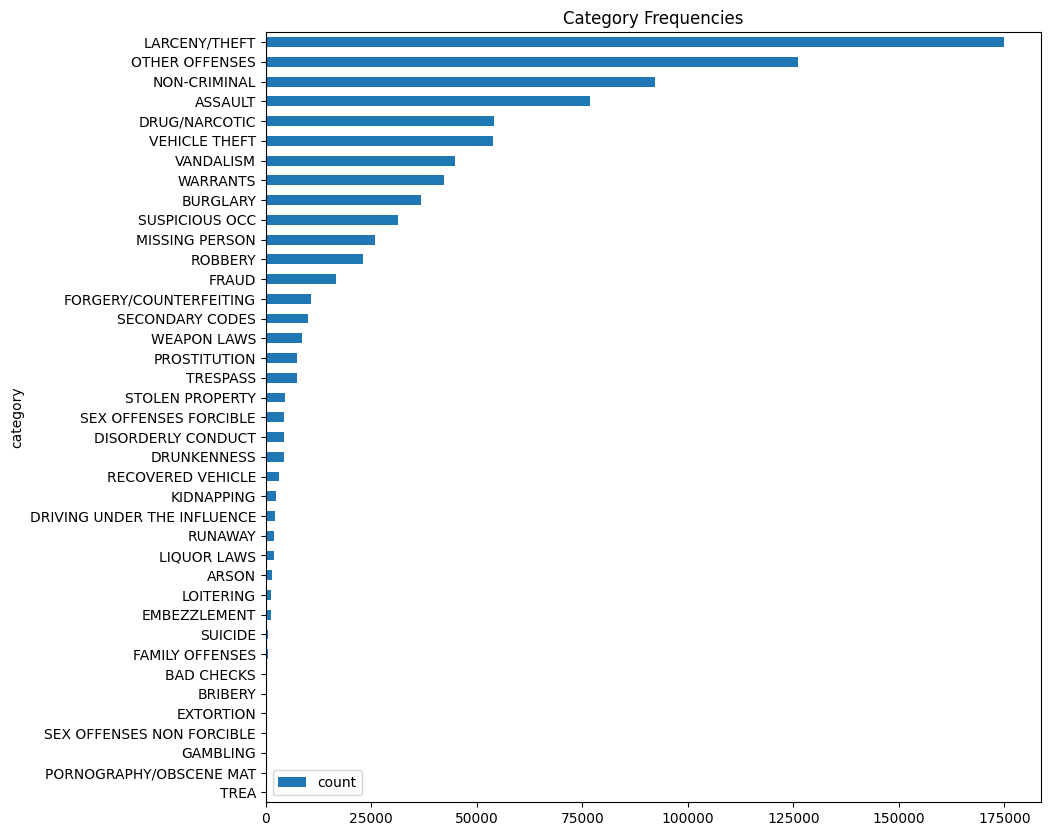

In [11]:
category_frequencies = df_train_raw.groupBy('category').count().orderBy('count', ascending=True)

category_frequencies.toPandas().plot.barh(x='category', y='count', figsize=(10, 10), title='Category Frequencies')

In [12]:
category_percentage = category_frequencies.withColumn('percentage', category_frequencies['count'] / df_train_raw.count() * 100)
category_percentage.orderBy('percentage', ascending=False).show()

+--------------------+------+------------------+
|            category| count|        percentage|
+--------------------+------+------------------+
|       LARCENY/THEFT|174900|19.919161686876244|
|      OTHER OFFENSES|126182|14.370724185096732|
|        NON-CRIMINAL| 92304|10.512397371900658|
|             ASSAULT| 76876| 8.755320033392215|
|       DRUG/NARCOTIC| 53971| 6.146695685548301|
|       VEHICLE THEFT| 53781| 6.125056802069133|
|           VANDALISM| 44725| 5.093679282135735|
|            WARRANTS| 42214| 4.807704353629467|
|            BURGLARY| 36755|4.1859850646148455|
|      SUSPICIOUS OCC| 31414|3.5777046611293906|
|      MISSING PERSON| 25989| 2.959857593368935|
|             ROBBERY| 23000|2.6194437895834968|
|               FRAUD| 16679|1.8995523028897021|
|FORGERY/COUNTERFE...| 10609|1.2082469201604922|
|     SECONDARY CODES|  9985|1.1371802712604877|
|         WEAPON LAWS|  8555|0.9743192008646442|
|        PROSTITUTION|  7484|0.8523442313583867|
|            TRESPAS

In [13]:
categories_top6_sum = category_percentage.orderBy('percentage', ascending=False).limit(6).select(_sum('percentage')).first()[0]
print(f"Percentage of the first 6 categories: {categories_top6_sum}")

Percentage of the first 6 categories: 65.82935576488329


#### Explore the PdDistrict column

There are 10 police districts in the dataset, but there is a class imbalance, since some districts are more frequent than others. In particular, the most frequent district is SOUTHERN, which is almost 18% of the dataset, while the least frequent district is RICHMOND, which is slightly more than 5% of the dataset.

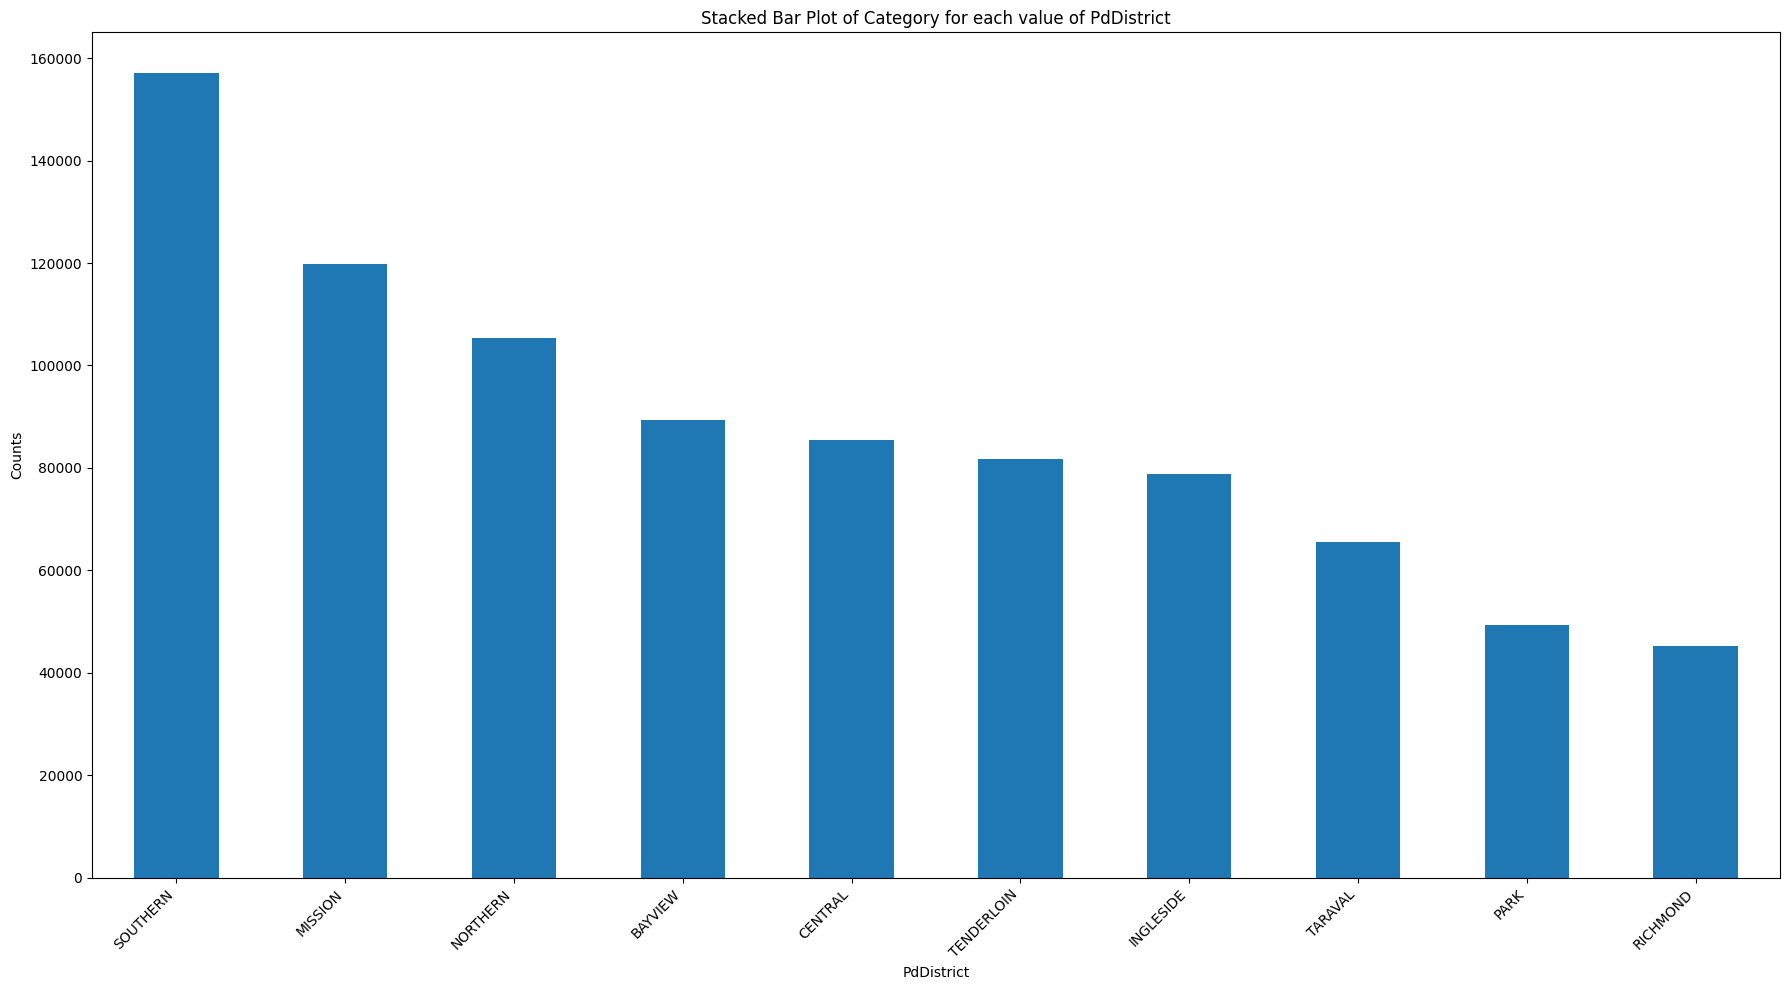

In [14]:
plot_label_sum_bars(df_train_raw, 'PdDistrict', 'Category', sort_by="label")

The crime distribution is not uniform across the districts, since some districts have a higher crime rate of certain crimes than others.

However, the most common crimes is LARCENY/THEFT in all the districts, except for BAYVIEW, TERNDERLOIN and INGLESIDE, where the most common crime is a different one. 

For example, in TENDERLOIN the most common crime is DRUG/NARCOTIC, while in BAYVIEW and INGLESIDE the most common crime is OTHER OFFENSES.

24/01/16 17:51:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


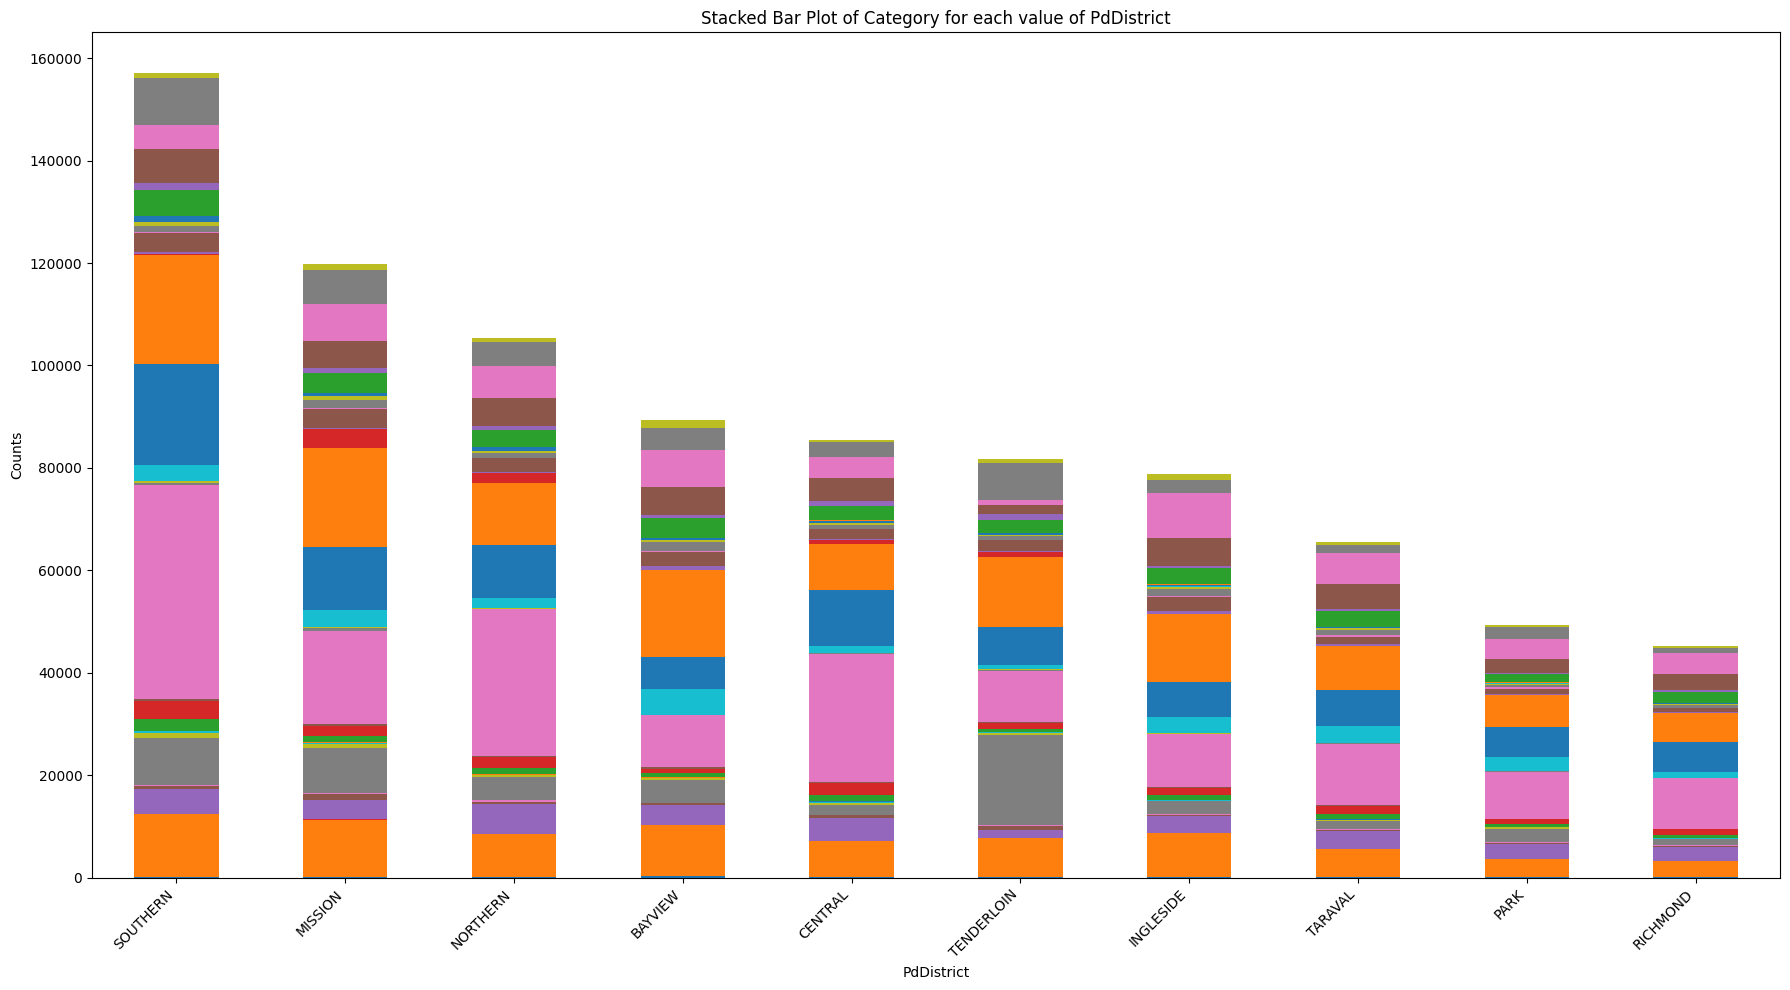

In [15]:
plot_stacked_bars(df_train_raw, 'PdDistrict', 'Category', sort_by="label")

Distribution of crimes in the SOUTHERN district. 

The distribution is similar to the overall distribution, since the most common crime is LARCENY/THEFT, followed by OTHER OFFENSES and NON-CRIMINAL.

In [21]:
df_train_raw.filter(df_train_raw['PdDistrict'] == 'SOUTHERN').groupBy('Category').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|            Category|count|
+--------------------+-----+
|       LARCENY/THEFT|41841|
|      OTHER OFFENSES|21307|
|        NON-CRIMINAL|19745|
|             ASSAULT|12183|
|       DRUG/NARCOTIC| 9228|
|            WARRANTS| 9101|
|           VANDALISM| 6550|
|      SUSPICIOUS OCC| 5065|
|            BURGLARY| 4841|
|       VEHICLE THEFT| 4724|
|             ROBBERY| 3878|
|               FRAUD| 3441|
|      MISSING PERSON| 3064|
|FORGERY/COUNTERFE...| 2345|
|            TRESPASS| 1456|
|     SECONDARY CODES| 1205|
|         WEAPON LAWS| 1128|
|     STOLEN PROPERTY| 1007|
|         DRUNKENNESS|  959|
|SEX OFFENSES FORC...|  818|
+--------------------+-----+
only showing top 20 rows



Distribution of crimes in the TENDERLOIN district.

In [25]:
df_train_raw.filter(df_train_raw['PdDistrict'] == 'TENDERLOIN').groupBy('Category').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|            Category|count|
+--------------------+-----+
|       DRUG/NARCOTIC|17696|
|      OTHER OFFENSES|13721|
|       LARCENY/THEFT| 9901|
|             ASSAULT| 7678|
|        NON-CRIMINAL| 7463|
|            WARRANTS| 7324|
|      SUSPICIOUS OCC| 2513|
|             ROBBERY| 2202|
|           VANDALISM| 1616|
|            BURGLARY| 1488|
|            TRESPASS| 1191|
|               FRAUD| 1130|
|       VEHICLE THEFT| 1004|
|        PROSTITUTION|  904|
|      MISSING PERSON|  833|
|  DISORDERLY CONDUCT|  833|
|         WEAPON LAWS|  794|
|     SECONDARY CODES|  724|
|FORGERY/COUNTERFE...|  562|
|         DRUNKENNESS|  439|
+--------------------+-----+
only showing top 20 rows



Percentage distribution of crimes in the all the districts.

In [16]:
district_frequencies = df_train_raw.groupBy('PdDistrict').count().orderBy('count', ascending=True)
district_percentage = district_frequencies.withColumn('percentage', district_frequencies['count'] / df_train_raw.count() * 100)
district_percentage.orderBy('percentage', ascending=False).show()

+----------+------+------------------+
|PdDistrict| count|        percentage|
+----------+------+------------------+
|  SOUTHERN|157182| 17.90127885801362|
|   MISSION|119908| 13.65618547484252|
|  NORTHERN|105296|11.992041446434083|
|   BAYVIEW| 89431|10.185194675923553|
|   CENTRAL| 85460| 9.732942011208943|
|TENDERLOIN| 81809| 9.317133781827666|
| INGLESIDE| 78845| 8.979567199552644|
|   TARAVAL| 65596| 7.470653687892134|
|      PARK| 49313| 5.616201373727434|
|  RICHMOND| 45209| 5.148801490577405|
+----------+------+------------------+



#### Explore the Year column

The crimes are distributed over 12 years, from 2003 to 2015. The most frequent year is 2013, while the least frequent year is 2015 since the dataset contains only the first 5 months of the year. 

However, there isn't a significant difference between the years, in fact except for 2015, the mean number of crimes per year is 70872, with a standard deviation of 3073, which means that the number of crimes per year is almost constant.

A different consideration can be made when considering the distribution of the distinct crimes over the years. In fact, the distribution of the crimes over the years is not uniform, since some crimes are more frequent in some years than others. 

For example, the number of crimes of the category LARCENY/THEFT has been constant over the years until 2012 and then it has started to increase constantly, while the number of crimes of the category VECHICLE THEFT has been higher until 2005 and then it has dropped and it has been constant since then. 

Some other crimes have a more uniform distribution over the years, for example the number of crimes of the category ASSAULT has been constant over the years.

In [17]:
print_mean_std_dev(df_train_raw, "Year", exclude_list=[2015])

+-----------------+
|       avg(count)|
+-----------------+
|70872.08333333333|
+-----------------+



+-----------------+
|    stddev(count)|
+-----------------+
|3073.674687297491|
+-----------------+



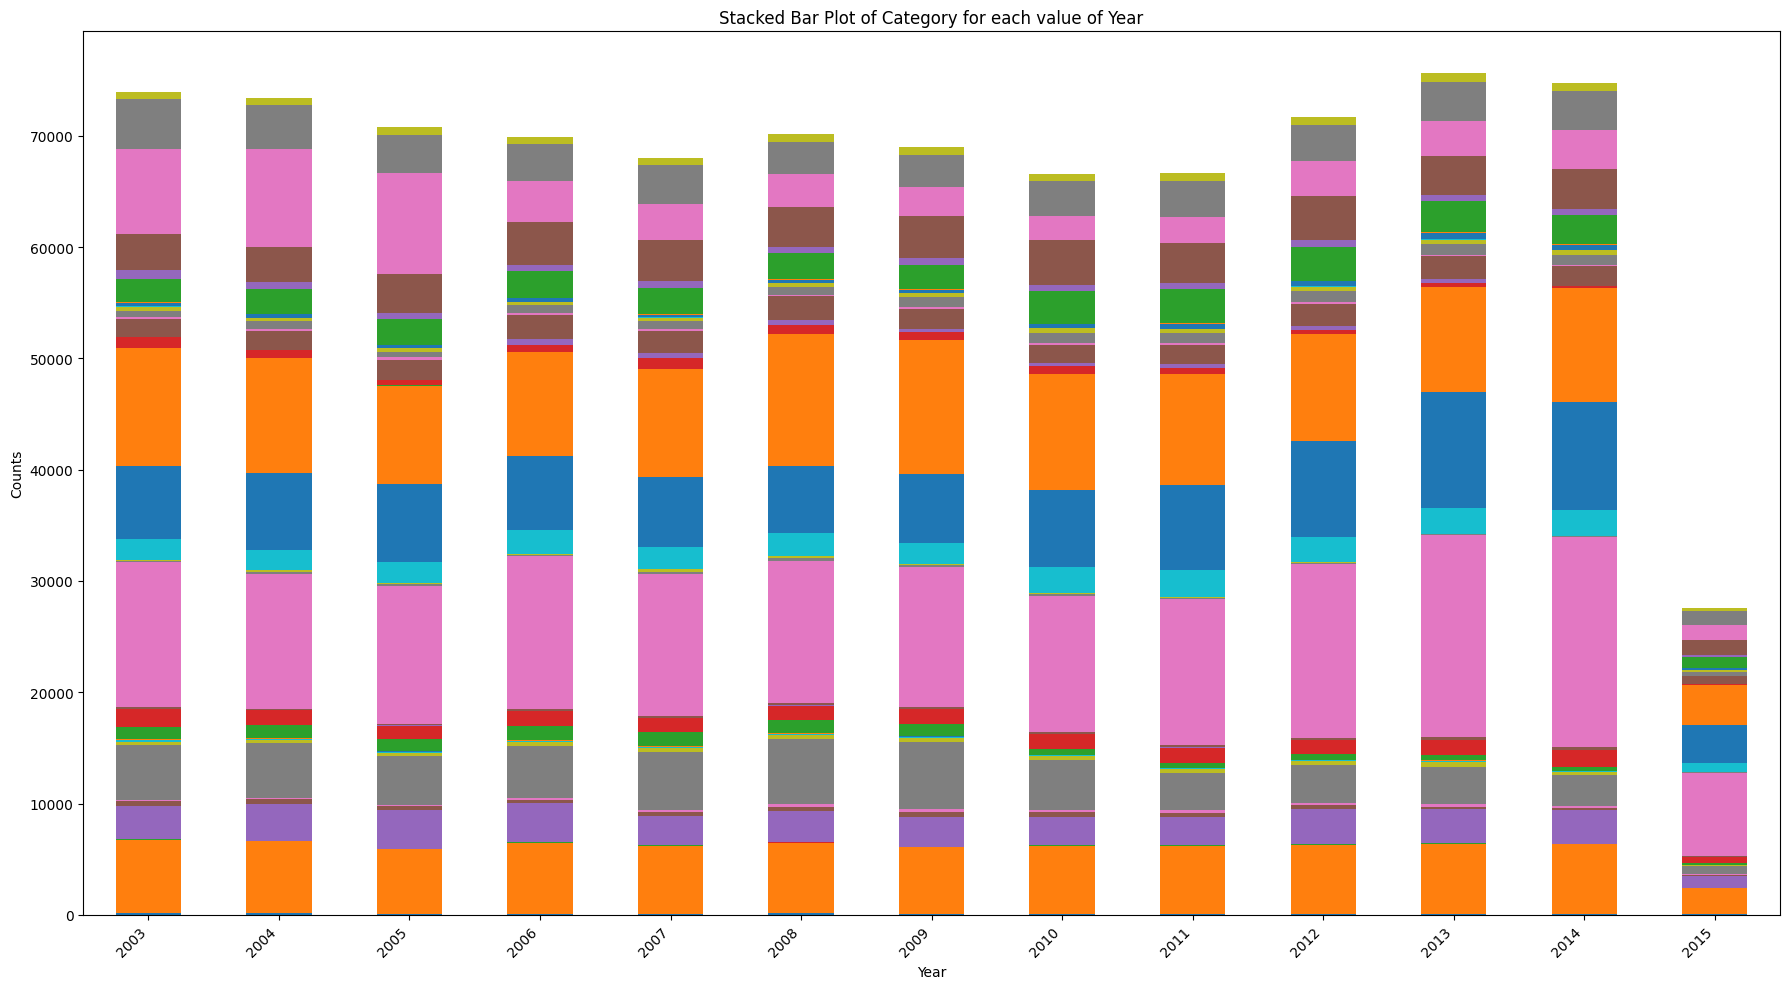

In [18]:
plot_stacked_bars(df_train_raw, 'Year', 'Category', sort_by="column")

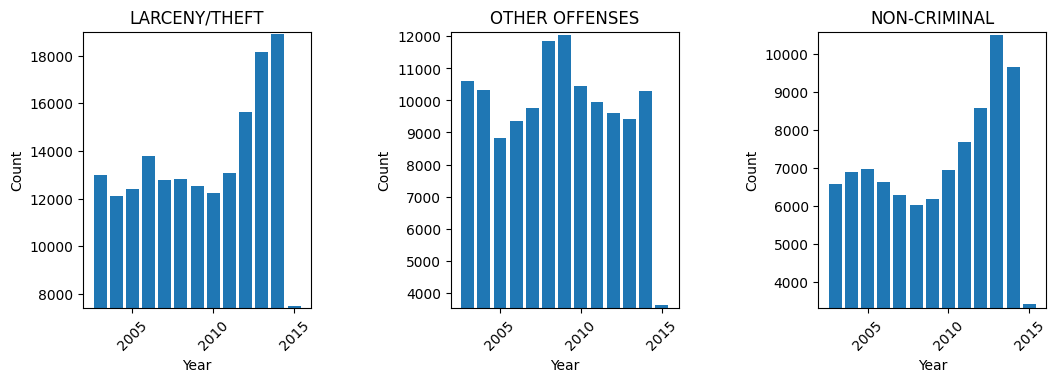

In [31]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'Year', limit_labels=3, figsize=(12, 5))

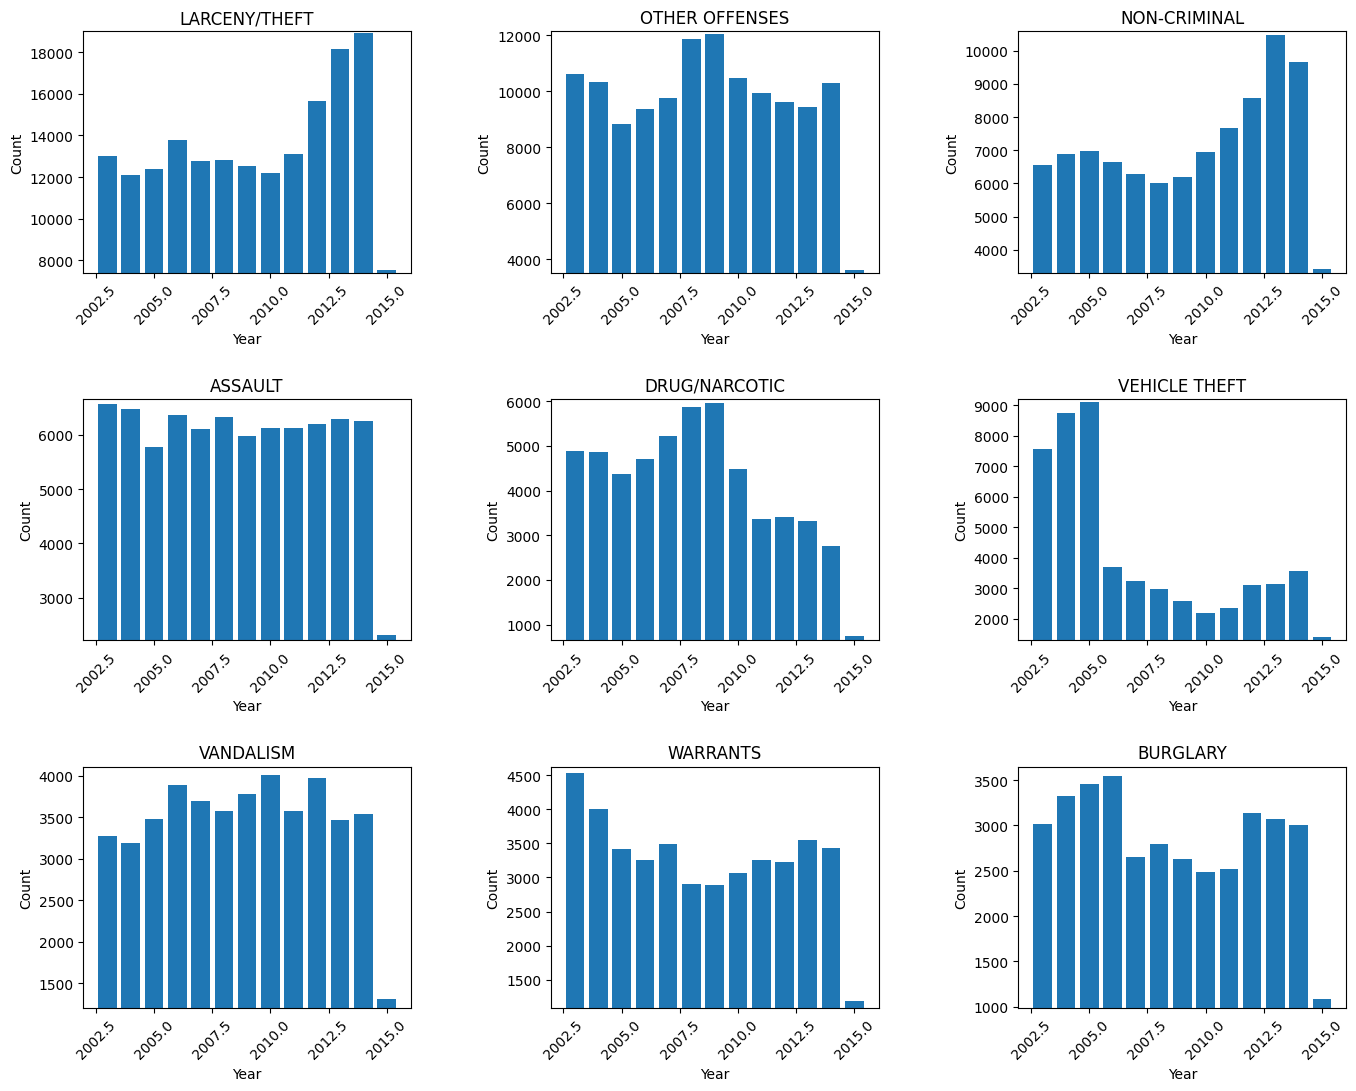

In [19]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'Year', limit_labels=9)

#### Explore the Month column

The crimes are distributed over the 12 months of the year. The most frequent month is October, while the least frequent month is December. There is a significant difference between the months compared to the years, with a decrease in the number of crimes in the summer months and December. 

For the top-6 crimes, the distribution is similar to the overall distribution.

In [20]:
print_mean_std_dev(df_train_raw, "Month")

+----------+
|avg(count)|
+----------+
|  73170.75|
+----------+



+-----------------+
|    stddev(count)|
+-----------------+
|4643.831844990239|
+-----------------+



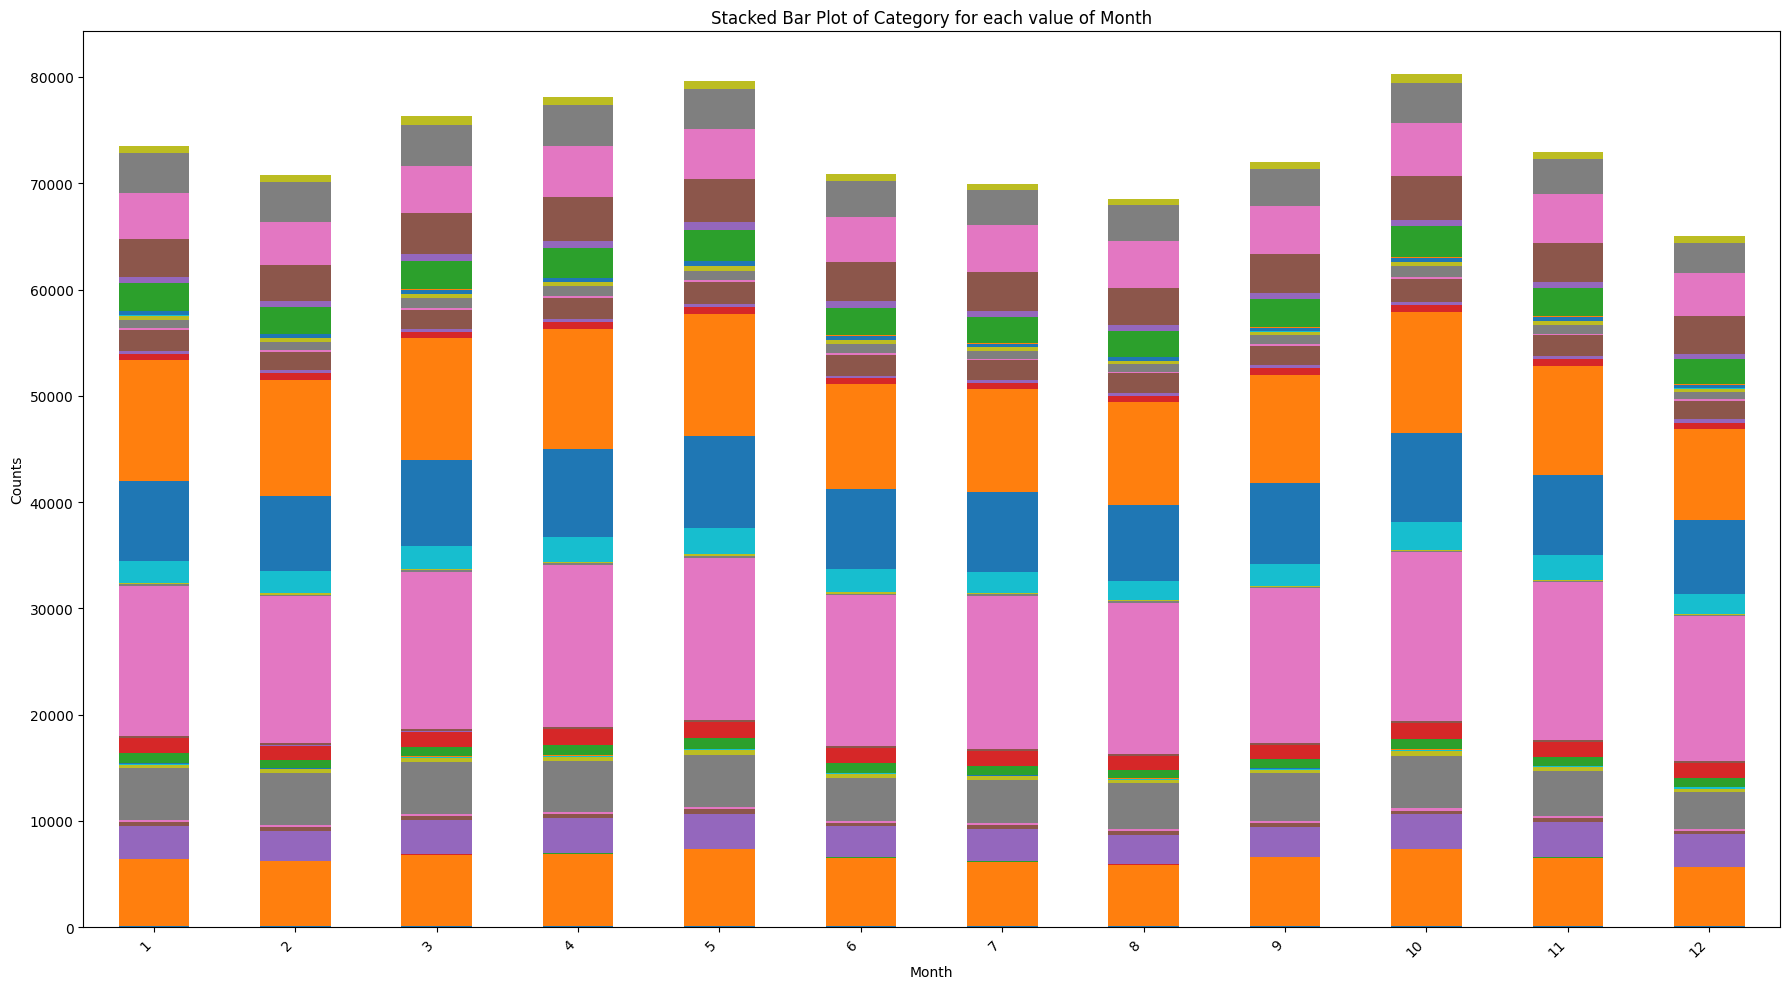

In [21]:
plot_stacked_bars(df_train_raw, 'Month', 'Category', sort_by="column")

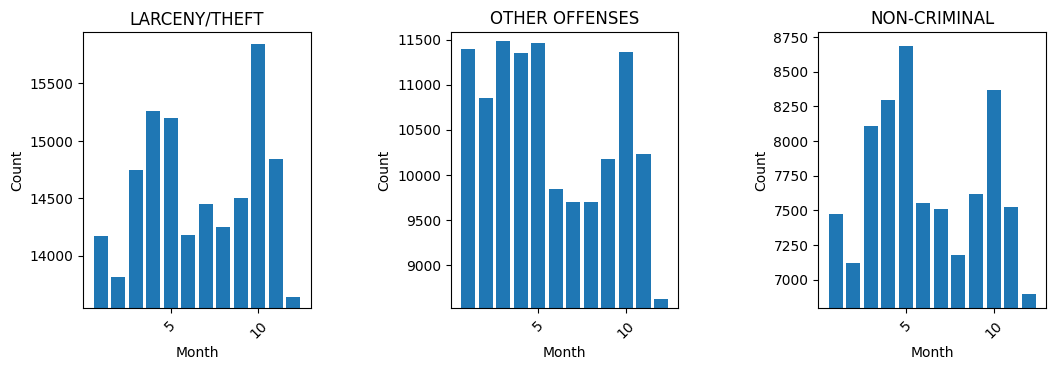

In [32]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'Month', limit_labels=3, figsize=(12, 5))

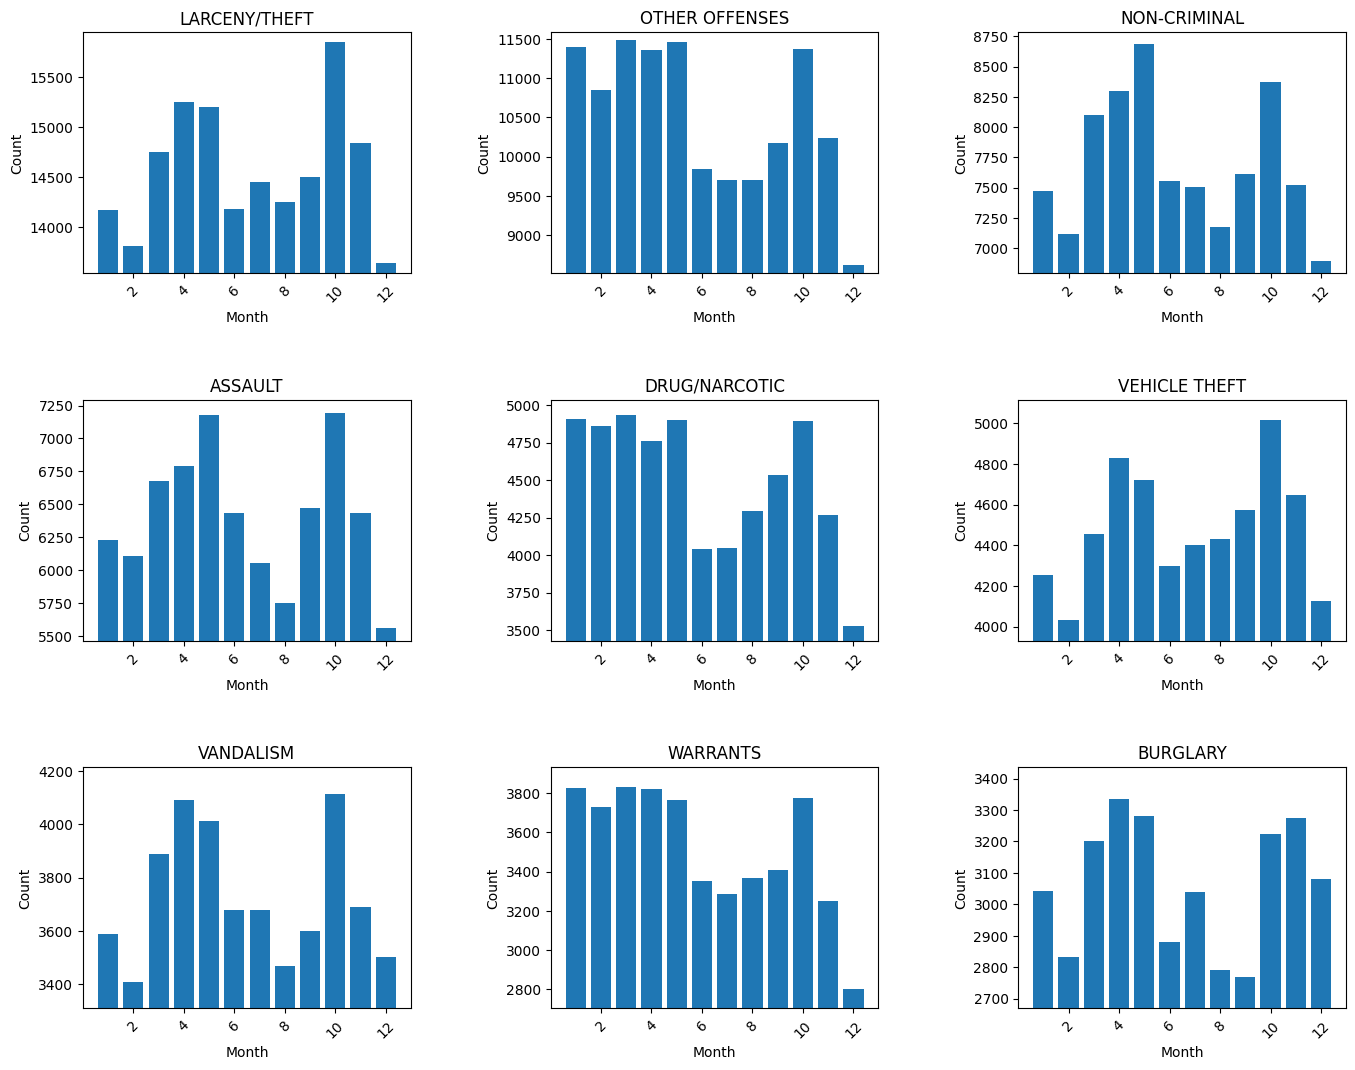

In [22]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'Month', limit_labels=9)

#### Explore the DayOfWeek column

The crimes are distributed over the 7 days of the week. The most frequent day is Friday, while the least frequent day is Sunday. 

For the top-6 crimes, the distribution is different from the overall distribution in some cases.

For example, the number of crimes of the category ASSAULT is higher on the weekends, especially on Sunday which is the least frequent day for the majority of the crimes.


In [23]:
print_mean_std_dev(df_train_raw, "DayOfWeek")

+------------------+
|        avg(count)|
+------------------+
|125435.57142857143|
+------------------+



+-----------------+
|    stddev(count)|
+-----------------+
|5422.313370298167|
+-----------------+



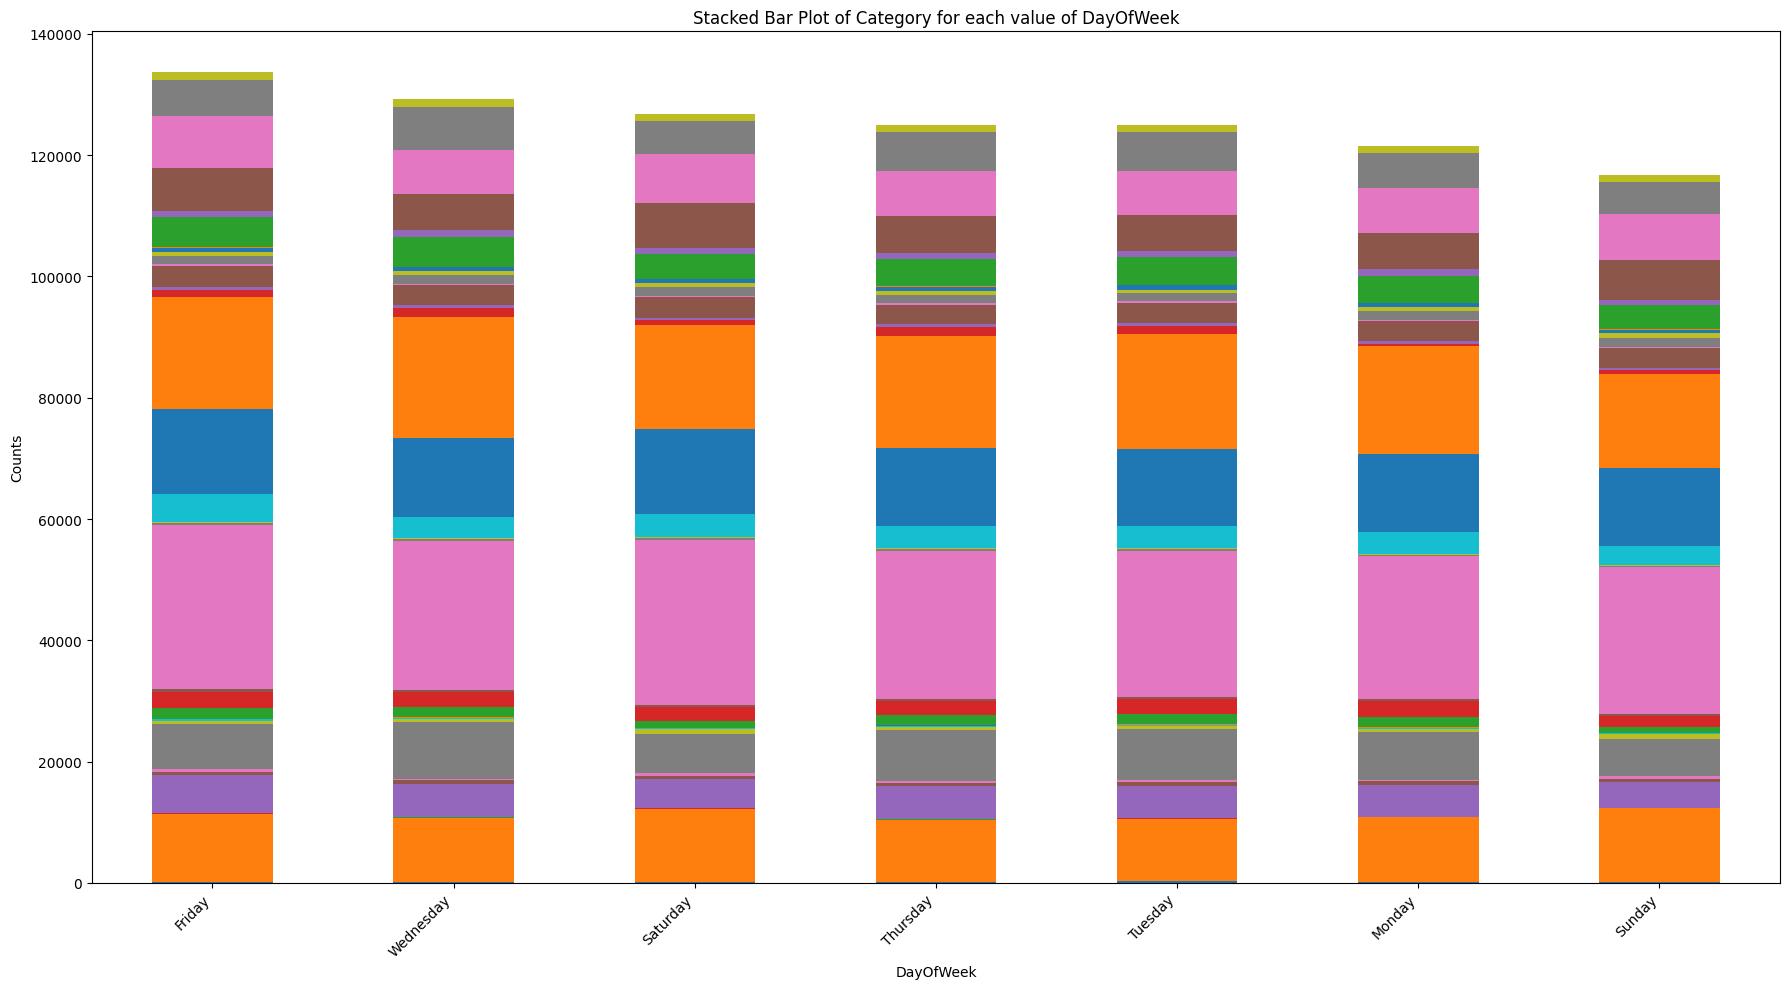

In [24]:
plot_stacked_bars(df_train_raw, 'DayOfWeek', 'Category', sort_by="label")

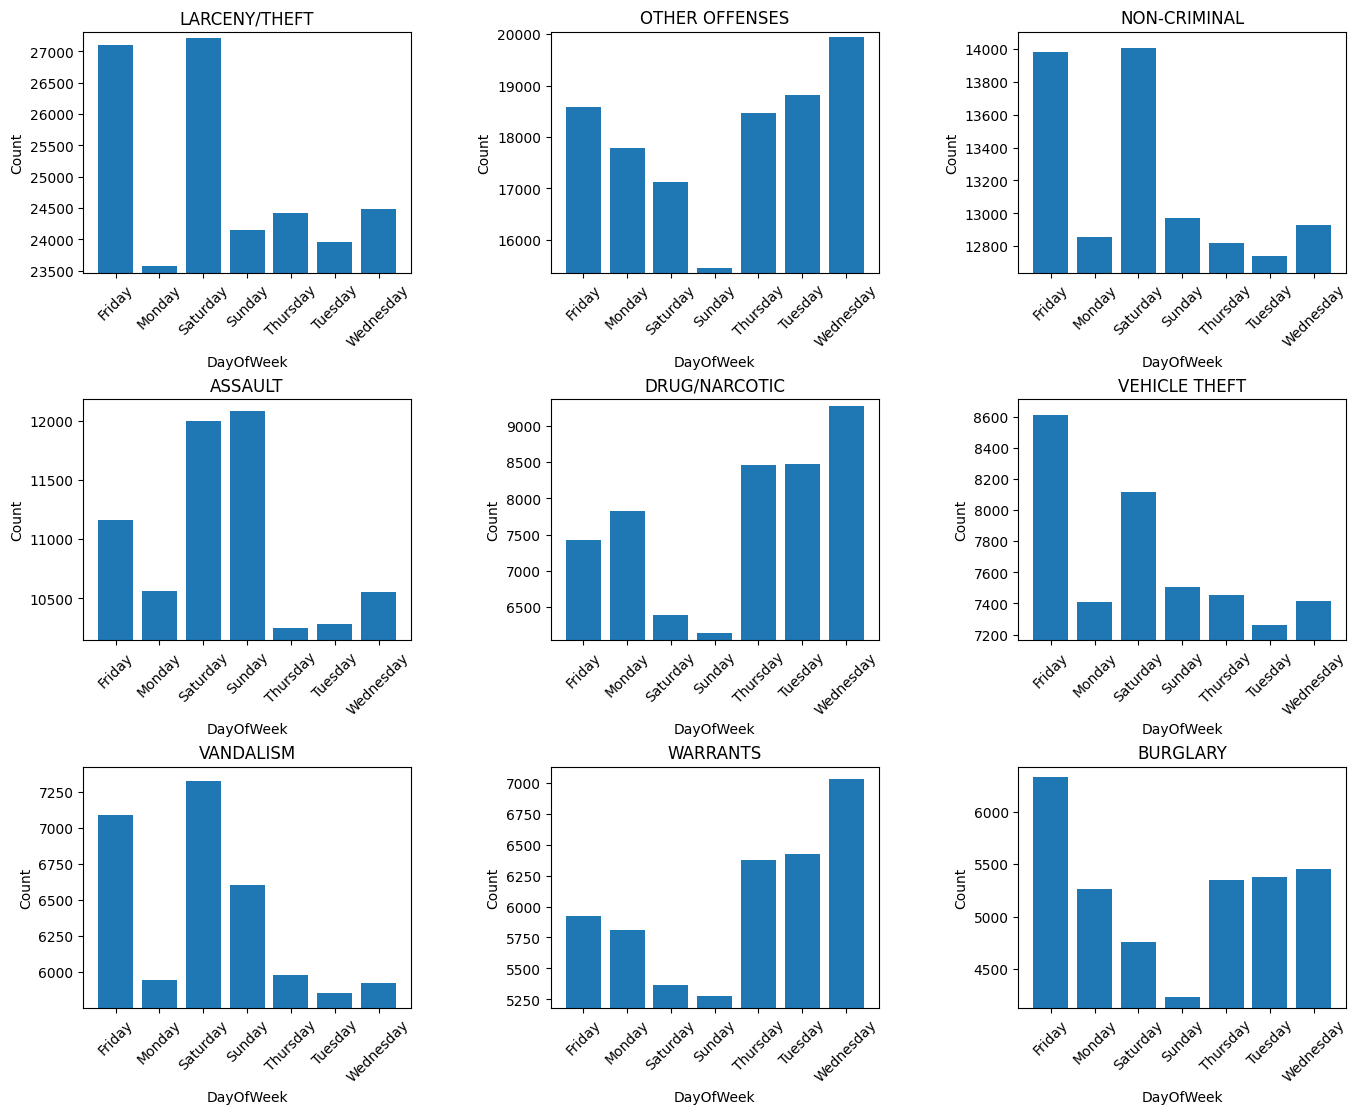

In [25]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'DayOfWeek', limit_labels=9)

#### Explore the Hour column

The crimes are distributed over the 24 hours of the day. The most frequent hour is 18, while the least frequent hour is 5.

In general, the number of crimes is higher during the day and it decreases during the night. 

This distribution is similar for the top-6 crimes when compared to the overall distribution, however there are some differences in some "night" crimes, for example the number of crimes of the category VECHICLE THEFT and VANADALISM is higher during the night. 

In [26]:
print_mean_std_dev(df_train_raw, "Hour")

+----------+
|avg(count)|
+----------+
| 36585.375|
+----------+



+-----------------+
|    stddev(count)|
+-----------------+
|14525.76740713909|
+-----------------+



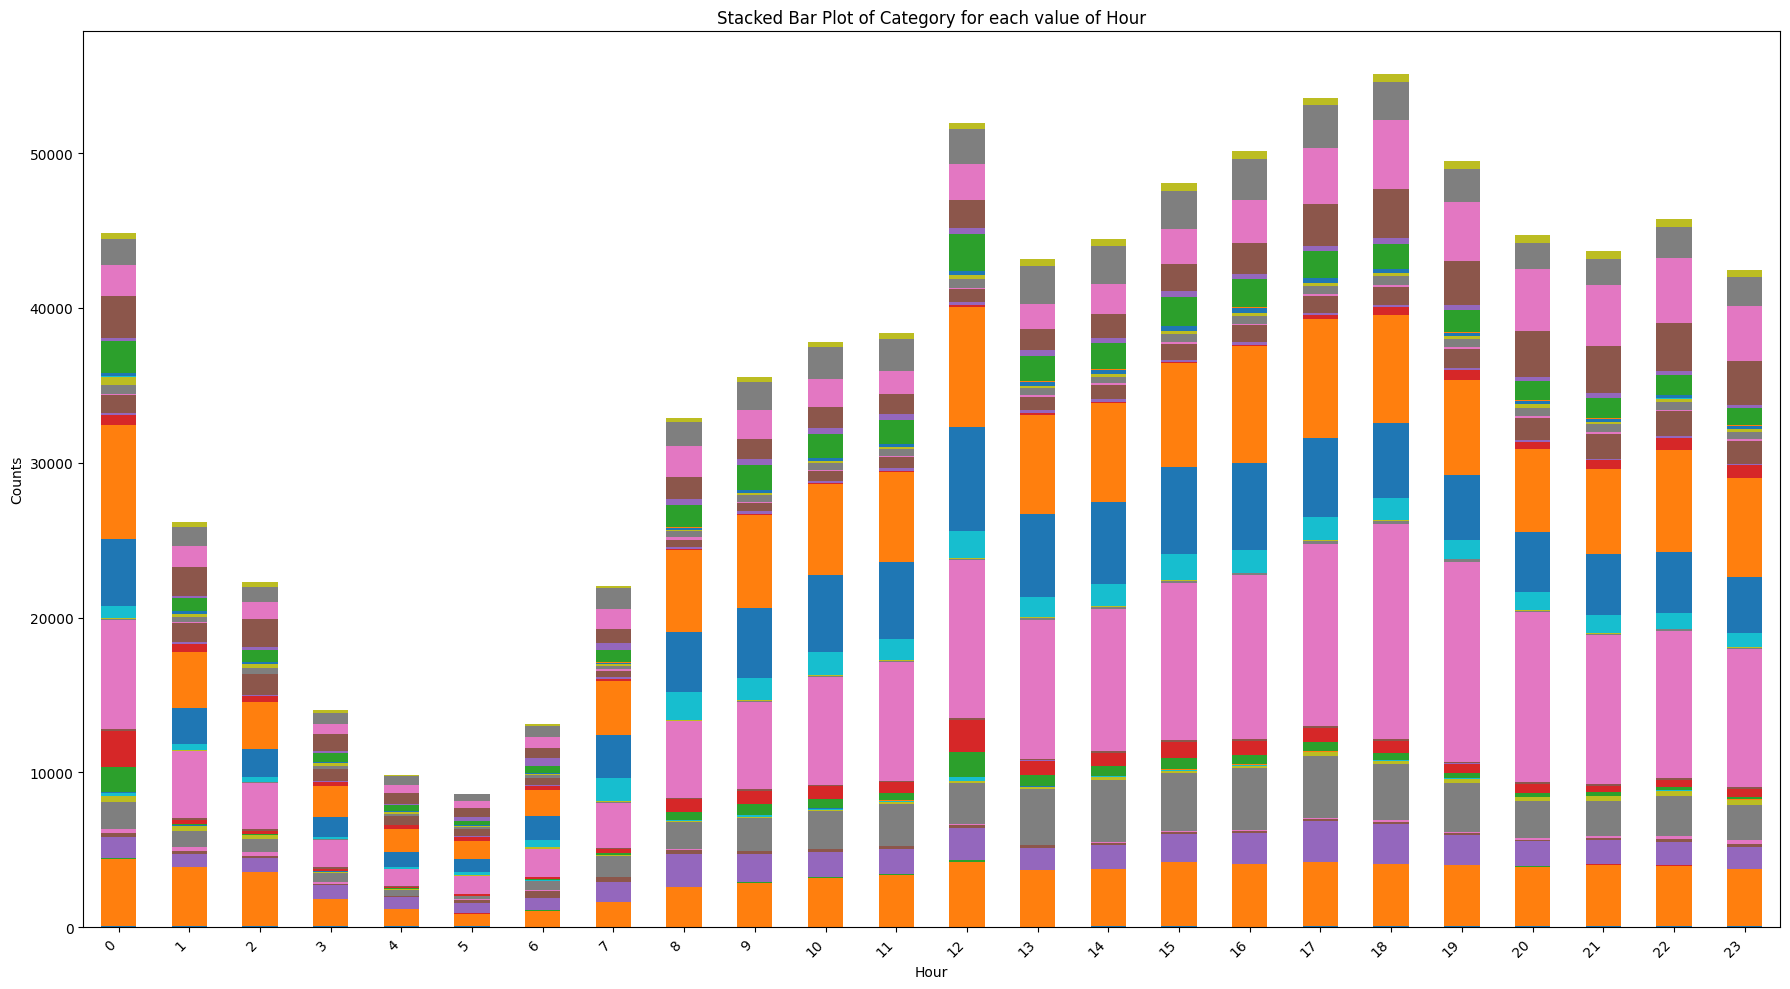

In [27]:
plot_stacked_bars(df_train_raw, 'Hour', 'Category', sort_by="column")

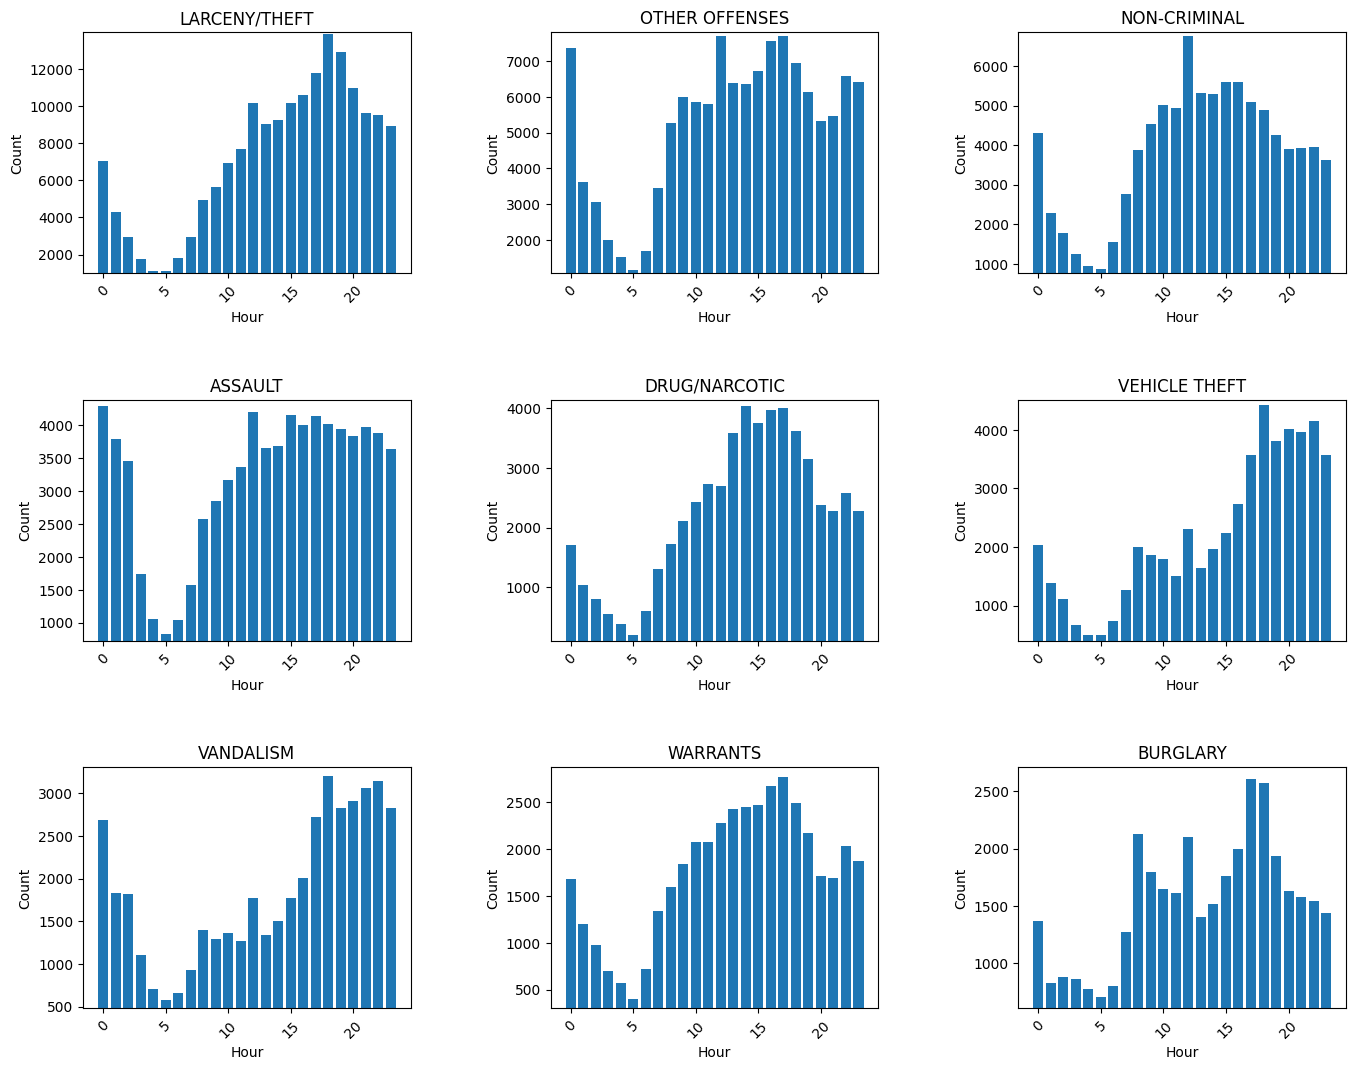

In [28]:
subplots_of_columns_over_labels(df_train_raw, 'Category', 'Hour', limit_labels=9)

#### Explore the X and Y column

There are 67 values for X and Y that are outside of San Francisco (probably wrong values), which can be removed.

The crimes are mostly distributed in the east part of the city.


<Axes: title={'center': 'Distribution of Crimes'}, xlabel='X', ylabel='Y'>

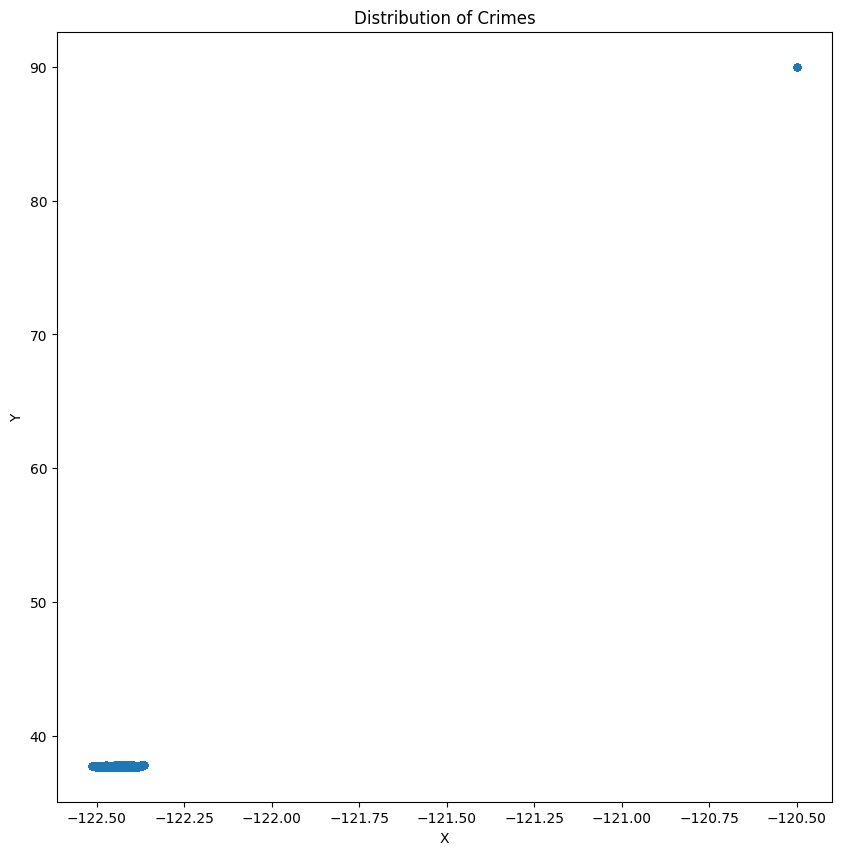

In [29]:
df_train_raw.select('X', 'Y').toPandas().plot.scatter(x='X', y='Y', figsize=(10, 10), title='Distribution of Crimes')

In [8]:
print(f"Number of rows with a non-valid longitude or latitude: {df_train_raw.filter((df_train_raw['X'] > -121) | (df_train_raw['Y'] > 40)).count()}")

df_train_raw = df_train_raw.filter((df_train_raw['X'] < -121) & (df_train_raw['Y'] < 40))

Number of rows with a non-valid longitude or latitude: 67


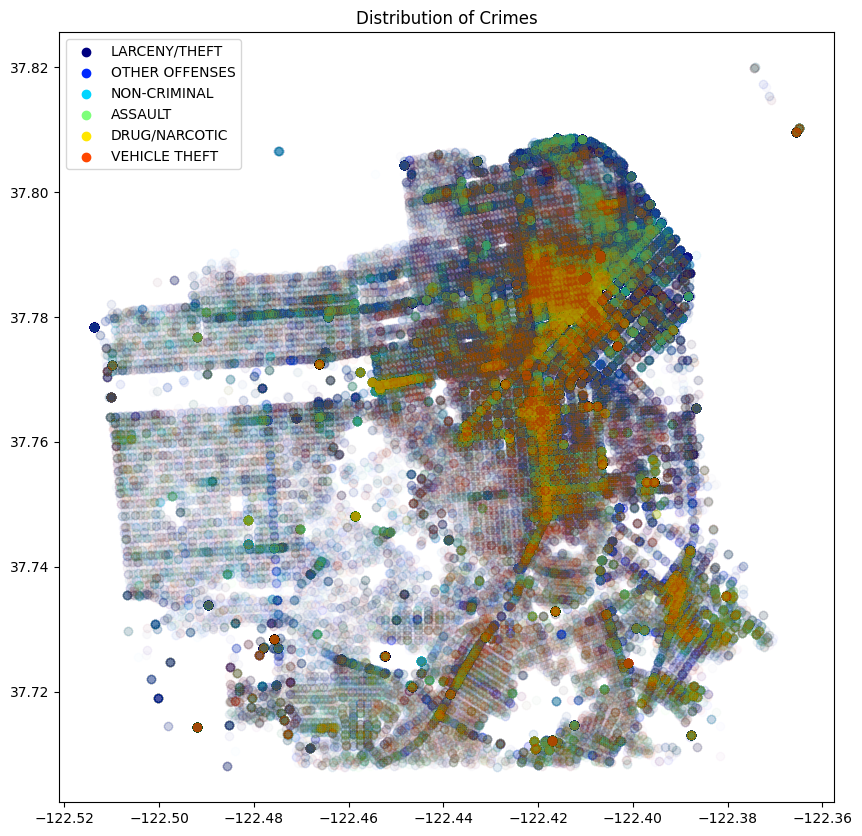

In [31]:
# df_train_raw.select('X', 'Y').toPandas().plot.scatter(x='X', y='Y', figsize=(10, 10), title='Distribution of Crimes', alpha=0.01)
# Get the categories and their counts
n_top = 6
categories = df_train_raw.groupBy('category').count().orderBy('count', ascending=False).limit(n_top).toPandas().category.tolist()
# Get the colors
colors = {category: colormaps["jet"](i / n_top) for i, category in enumerate(categories)}

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
for category in categories:
    category_data = df_train_raw.filter(df_train_raw['Category'] == category).select('X', 'Y').toPandas()
    ax.scatter(category_data['X'], category_data['Y'], label=category, color=colors[category], alpha=0.01)

ax.set_title('Distribution of Crimes')
leg = ax.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
plt.show()

## Train and test the model

The tested models will vary in **complexity**, from the simplest ones (e.g. Logistic Regression) to the most complex ones (e.g. Neural Networks), with different features to be used, in order to show the impact of the features on the performance of the model.

The first model has as features the **PdDistrict** and the **DayOfWeek**, which are categorical features, which are encoded using StringIndexer only. 

The baseline model is a **Logistic Regression**, which is a simple model that can be used as a baseline for the other models and evaluate the impact of the features and the complexity of the model on the performance.

- **Baseline model**: Logistic Regression with the following features: PdDistrict, DayOfWeek
- **Improved baseline model**: Naive Bayes and Random Forest with the same features of the baseline model

Then, the model will be improved by further preprocessing the data, i.e. the DayOfWeek and the PdDistrict features will be encoded using **OneHotEncoder**, in order to improve the performance of the model. The model will be the same as the baseline model.

In the third model, the features will be increased by adding together the **Year**, **Month** and **Hour** features, which are discrete numerical features.

Finally, the fourth model will be the same as the third model, but the features will be further increased by adding the **X** and **Y** features, which can be encoded either with **GridEncoding** or **clustering** techniques.

A different approach can be used for the **X** and **Y** features, since they are coordinates and they can be just used as they are, after applying a **normalization technique** (StandardScaler). The tested models are a **Neural Network** and a **Random Forest**.

The models will be evaluated using the following metrics:
- **F1 score**: the dataset is unbalanced, hence the F1 score is a better metric than the accuracy
- **Multiclass Log Loss**: the metric used by Kaggle to evaluate the performance of the modelus features.


In [9]:
# define the evaluation function (f1, precision, recall, and multiclass log loss)
def evaluate(predictions):
    # Select (prediction, true label) and compute test error
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    evaluator_log_loss = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="logLoss")

    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    log_loss = evaluator_log_loss.evaluate(predictions)

    print(f"f1 score: {f1}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"log loss: {log_loss}")

def print_metrics(dfs, df_names, model, model_name):
    for dataset, name in zip(dfs, df_names):
        predictions = model.transform(dataset)
        print(f"Evaluation of the {model_name} model on the {name} dataset:")
        evaluate(predictions)

def train_evaluate_model(encoder_pipeline, model_dict, df_train, df_validation=None, df_test=None):
    model = model_dict['model'](**model_dict['params'])
    # Define the pipeline model
    pipeline_model = Pipeline(stages=[encoder_pipeline, model])
    # Train the model
    model = pipeline_model.fit(df_train)

    df_names = ['train']
    dfs = [df_train]
    if df_validation is not None:
        df_names.append('validation')
        dfs.append(df_validation)
    if df_test is not None:
        df_names.append('test')
        dfs.append(df_test)
        
    print_metrics(dfs, df_names, model, model_dict['name'])

Split the dataset into train, test and validation sets. The validation set will be used for the hyperparameter tuning of the clustering algorithm.

It's always better to split the dataset into train and test sets before applying any preprocessing, in order to avoid data leakage (e.g. statistics of the test set used for preprocessing the train set).

In [10]:
# split in train, validation and test
df_train, df_validation, df_test = df_train_raw.randomSplit([0.6, 0.2, 0.2], seed=SEED)

# print the number of rows in each dataset
print(f"Train dataset\nRows: {df_train.count()}\nColumns: {len(df_train.columns)}", end="\n\n")
print(f"Validation dataset\nRows: {df_validation.count()}\nColumns: {len(df_validation.columns)}", end="\n\n")
print(f"Test dataset\nRows: {df_test.count()}\nColumns: {len(df_test.columns)}")

Train dataset
Rows: 526658
Columns: 8



Validation dataset
Rows: 175862
Columns: 8



Test dataset
Rows: 175462
Columns: 8


Encode the labels using StringIndexer: this is in common for all the models.

In [11]:
# Index the 'Category' column to create labels for prediction
label_stringIdx = StringIndexer(inputCol='Category', outputCol='label')

These dictionaries contains the tested models and the corresponding hyperparameters. The models are tested wherever it is possible to use standard hyperparameters.

In [57]:
lr_model_dict = {'model': LogisticRegression, 'params': {}, 'name': 'Logistic Regression'}
nb_model_dict = {'model': NaiveBayes, 'params': {'modelType': 'multinomial'}, 'name': 'Naive Bayes'}
# rf_model_dict = {'model': RandomForestClassifier, 'params': {'labelCol': 'label', 'featuresCol': 'features', 'numTrees': 150, 'maxDepth': 20}, 'name': 'Random Forest'}
rf_model_dict = {'model': RandomForestClassifier, 'params': {'labelCol': 'label', 'featuresCol': 'features', 'numTrees': 150}, 'name': 'Random Forest'}
# rf_model_dict = {'model': RandomForestClassifier, 'params': {'labelCol': 'label', 'featuresCol': 'features'}, 'name': 'Random Forest'}
nn_model_dict = {'model': MultilayerPerceptronClassifier, 'params': {'labelCol': 'label', 'featuresCol': 'features', 'maxIter': 100, 'layers': [63, 128, 64, 39]}, 'name': 'Neural Network'}

### Baseline model

The baseline model is a Logistic Regression and the features are the PdDistrict and the DayOfWeek, encoded using StringIndexer onl

Then, Naive Bayes and Random Forest will be used to compare the performance of the models using the same features.

The best model is the Random Forest, which has a better F1 score and a lower Log Loss than the other models.

The models doesn't exhibit overfitting, since the performance on the test set is similar to the performance on the train set.

In [13]:
# StringIndexer encode the 'DayOfWeek' and 'PdDistrict' columns
day_of_week_indexer = StringIndexer(inputCol='DayOfWeek', outputCol='DayOfWeekIndex')
pd_district_indexer = StringIndexer(inputCol='PdDistrict', outputCol='PdDistrictIndex')

# Assemble the encoded features into a single feature vector
assembler = VectorAssembler(inputCols=['DayOfWeekIndex', 'PdDistrictIndex'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline = Pipeline(stages=pipeline_stages)

#### Logistic Regression

Logistic Regression is a simple model that can be used as a baseline for the other models and evaluate the impact of the features and the complexity of the model on the performance.

Since the task is a multi-class classification, the model is trained as Multinomial Logistic Regression, which is a generalization of the Logistic Regression for multi-class classification where the conditional probability of the output variable is modeled as a softmax function.

The model is trained using the default hyperparameters, since the dataset is large and the default hyperparameters are usually a good starting point.

The model doesn't exhibit overfitting, however the performance is not good.

In [17]:
# Train and evaluate the Logistic Regression model
train_evaluate_model(pipeline, lr_model_dict, df_train, df_validation, df_test)

Evaluation of the Logistic Regression model on the train dataset:


f1 score: 0.06624647029757534
precision: 0.03972507708479376
recall: 0.19931150765772096
log loss: 2.671186700510042
Evaluation of the Logistic Regression model on the validation dataset:


f1 score: 0.06573323549230395
precision: 0.03938959348391194
recall: 0.19846811704632042
log loss: 2.674239310714178
Evaluation of the Logistic Regression model on the test dataset:


f1 score: 0.06639036398678161
precision: 0.03981919692046671
recall: 0.19954748036611916
log loss: 2.6727204643158324


#### Naive Bayes

Naive Bayes is a model which assumes that the features are independent and it predicts the probability of each class using the Bayes theorem, hence it predicts the probability of each class given the features (the posterior probability).

Since it applies the Bayes theorem, it makes the assumption that the features are independent, which is not true in most cases.

The model is trained using the default hyperparameters, with smoothing enabled and set to 1.0 (default value).

The model doesn't exhibit overfitting, however the performance is on par with the Logistic Regression.

In [18]:
# Train and evaluate the Naive Bayes model
train_evaluate_model(pipeline, nb_model_dict, df_train, df_validation, df_test)

Evaluation of the Naive Bayes model on the train dataset:


f1 score: 0.06790563409914295
precision: 0.057147969176539276
recall: 0.19863554716723186
log loss: 2.677189041444779
Evaluation of the Naive Bayes model on the validation dataset:


f1 score: 0.06739314400421573
precision: 0.05657399021407695
recall: 0.197774391284075
log loss: 2.680261120657363
Evaluation of the Naive Bayes model on the test dataset:


f1 score: 0.06801322934818461
precision: 0.05603064400071206
recall: 0.1987495868051202
log loss: 2.6784592285528093


#### Random Forest

Random Forest is a family of models which are based on decision trees and it predicts the probability of each class using the majority vote of the trees. The model is more complex than the previous ones, but it is more flexible and it can capture complex relationships between features.

The model is trained using the default hyperparameters, however as will be shown later, the model can be improved by tuning the hyperparameters, but in this setup it results in out-of-memory errors.

In [14]:
# Train and evaluate the Random Forest model
train_evaluate_model(pipeline, rf_model_dict, df_train, df_validation, df_test)

24/01/18 08:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1366.7 KiB
24/01/18 08:13:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:14:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/01/18 08:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1390.5 KiB
24/01/18 08:15:09 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/01/18 08:15:55 WARN DAGScheduler: Broadcasting large task binary with size 1525.8 KiB
24/01/18 08:16:01 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
24/01/18 08:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1443.4 KiB
24/01/18 08:16:58 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
24/01/18 08:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1037.5 KiB
24/01/18 08:17:59 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
24/01/18 08:18:54 WARN DAGScheduler:

Evaluation of the Random Forest model on the train dataset:


24/01/18 08:19:49 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1350.8 KiB
24/01/18 08:23:20 WARN DAGScheduler: Broadcasting large task binary with size 1351.8 KiB


f1 score: 0.121743629237494
precision: 0.08629498339363256
recall: 0.22047134952853656
log loss: 2.6222500295407554
Evaluation of the Random Forest model on the validation dataset:


24/01/18 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1350.8 KiB
24/01/18 08:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1351.8 KiB


f1 score: 0.1221273272377622
precision: 0.0866773770588791
recall: 0.2208720474008029
log loss: 2.627030386021785
Evaluation of the Random Forest model on the test dataset:


24/01/18 08:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1348.9 KiB
24/01/18 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1350.8 KiB
24/01/18 08:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1351.8 KiB


f1 score: 0.12274039613780431
precision: 0.08692879753927336
recall: 0.22195689095074714
log loss: 2.6241857562028437


### Baseline model with OneHotEncoder

The features are encoded using OneHotEncoder, which is a better encoding technique than StringIndexer, since it doesn't introduce any order in the features. In fact, the StringIndexer encodes the features using an index, which introduces an order in the features, which is not true in most cases.

For example, there isn't an order between the days of the week (Monday is not greater than Tuesday) nor between the police districts (BAYVIEW is not greater than SOUTHERN).

However, the OneHotEncoder introduces a lot of features, which can be a problem for the performance of the model, since it increases the dimensionality of the dataset. 

This is not a problem for the Logistic Regression or the Naive Bayes, since they are linear models and they can handle a large number of features, but it can be a problem for the Random Forest, since it is a non-linear model and it can overfit or require a lot of memory.

In fact, the Random Forest with the OneHotEncoder has a lower F1 score and a higher Log Loss than the Random Forest with the StringIndexer.

In [14]:
day_of_week_encoder = OneHotEncoder(inputCol='DayOfWeekIndex', outputCol='DayOfWeekVec')
pd_district_encoder = OneHotEncoder(inputCol='PdDistrictIndex', outputCol='PdDistrictVec')

assembler = VectorAssembler(inputCols=['DayOfWeekVec', 'PdDistrictVec'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   day_of_week_encoder, pd_district_encoder,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline_onehot = Pipeline(stages=pipeline_stages)

Logistic Regression

In [20]:
# Train and evaluate the Logistic Regression model
train_evaluate_model(pipeline_onehot, lr_model_dict, df_train, df_validation, df_test)

24/01/17 19:55:22 WARN BlockManager: Asked to remove block broadcast_391, which does not exist


Evaluation of the Logistic Regression model on the train dataset:


f1 score: 0.1225564689218666
precision: 0.08664198266878587
recall: 0.2203821075536686
log loss: 2.610715076440584
Evaluation of the Logistic Regression model on the validation dataset:


f1 score: 0.12295414032205339
precision: 0.08700320892991101
recall: 0.22091753761472063
log loss: 2.6147383022836865
Evaluation of the Logistic Regression model on the test dataset:


f1 score: 0.123662029993936
precision: 0.0873585528907618
recall: 0.22215066510127549
log loss: 2.6129069760466304


Naive Bayes

In [22]:
# Train and evaluate the Naive Bayes model
train_evaluate_model(pipeline_onehot, nb_model_dict, df_train, df_validation, df_test)

Evaluation of the Naive Bayes model on the train dataset:


f1 score: 0.12245978412198429
precision: 0.08659253938978258
recall: 0.22042388039296848
log loss: 2.6149335771577205
Evaluation of the Naive Bayes model on the validation dataset:


f1 score: 0.1226559210975455
precision: 0.08681486946176296
recall: 0.22058204728707737
log loss: 2.618993070617164
Evaluation of the Naive Bayes model on the test dataset:


f1 score: 0.12327507996895871
precision: 0.08710967794976807
recall: 0.2216719289646761
log loss: 2.616879551639746


Random Forest

In [18]:
# Train and evaluate the Random Forest model
train_evaluate_model(pipeline_onehot, rf_model_dict, df_train, df_validation, df_test)

24/01/18 08:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1168.1 KiB
24/01/18 08:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1840.8 KiB


Evaluation of the Random Forest model on the train dataset:


f1 score: 0.10855635871455176
precision: 0.0841743231538707
recall: 0.21584026066251724
log loss: 2.6278189501710334
Evaluation of the Random Forest model on the validation dataset:


f1 score: 0.10860567767638521
precision: 0.08449586333141038
recall: 0.21543028056089433
log loss: 2.631408313176478
Evaluation of the Random Forest model on the test dataset:


f1 score: 0.1093861757686696
precision: 0.0847074395032131
recall: 0.21687316911923948
log loss: 2.6292332466263777


### Model with Year, Month and Hour features

At this point, the features are increased by adding together the Year, Month and Hour features (initially they were treated as a single feature, the Dates feature).

As mentioned in the data exploration section, these features can have an impact on the performance of the model, in fact the crimes are not uniformly distributed over the years, months and hours, rather some crimes are more frequent in some periods than others, hence the model can learn these patterns and improve the performance.

Since the Random Forest has some memory issues, the model is trained with default hyperparameters, however the model can be improved by tuning the hyperparameters.

The logistic regression and the Naive Bayes have improved performance when compared to the previous models, hence the features are useful for the model.

The features are encoded using OneHotEncoder, since it has a better performance than the StringIndexer.

In [15]:
year_indexer = StringIndexer(inputCol='Year', outputCol='YearIndex')
month_indexer = StringIndexer(inputCol='Month', outputCol='MonthIndex')
hour_indexer = StringIndexer(inputCol='Hour', outputCol='HourIndex')

year_encoder = OneHotEncoder(inputCol='YearIndex', outputCol='YearVec')
month_encoder = OneHotEncoder(inputCol='MonthIndex', outputCol='MonthVec')
hour_encoder = OneHotEncoder(inputCol='HourIndex', outputCol='HourVec')

assembler = VectorAssembler(inputCols=['DayOfWeekVec', 'PdDistrictVec', 'YearVec', 'MonthVec', 'HourVec'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   year_indexer, month_indexer, hour_indexer,
                   day_of_week_encoder, pd_district_encoder,
                   year_encoder, month_encoder, hour_encoder,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline_dates = Pipeline(stages=pipeline_stages)

Logistic Regression

In [24]:
# Train and evaluate the Logistic Regression model
train_evaluate_model(pipeline_dates, lr_model_dict, df_train, df_validation, df_test)

Evaluation of the Logistic Regression model on the train dataset:


f1 score: 0.14283794740830555
precision: 0.15738147384465512
recall: 0.22791830751645276
log loss: 2.555927623397454
Evaluation of the Logistic Regression model on the validation dataset:


f1 score: 0.14323291883134762
precision: 0.15763337689322754
recall: 0.22854852099942
log loss: 2.562766230673468
Evaluation of the Logistic Regression model on the test dataset:


f1 score: 0.14442599307195236
precision: 0.1658384354460412
recall: 0.22979904480742266
log loss: 2.5605694416890015


Naive Bayes

In [25]:
# Train and evaluate the Naive Bayes model
train_evaluate_model(pipeline_dates, nb_model_dict, df_train, df_validation, df_test)

Evaluation of the Naive Bayes model on the train dataset:


f1 score: 0.14171018580984415
precision: 0.15675651404828106
recall: 0.22710563591552774
log loss: 2.562781527838353
Evaluation of the Naive Bayes model on the validation dataset:


f1 score: 0.14208702015945832
precision: 0.1577007932594821
recall: 0.2275477362932299
log loss: 2.5694951549985188
Evaluation of the Naive Bayes model on the test dataset:


f1 score: 0.14289099365762803
precision: 0.15827896614923348
recall: 0.22844262575372448
log loss: 2.566704637323562


Random Forest

In [20]:
# Train and evaluate the Random Forest model
train_evaluate_model(pipeline_dates, rf_model_dict, df_train, df_validation, df_test)

24/01/18 08:42:40 WARN DAGScheduler: Broadcasting large task binary with size 1428.9 KiB
24/01/18 08:43:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


Evaluation of the Random Forest model on the train dataset:


24/01/18 08:44:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:44:58 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:46:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:46:52 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


f1 score: 0.08261743172438998
precision: 0.06950681063502714
recall: 0.2049242582472876
log loss: 2.627932061917719


Evaluation of the Random Forest model on the validation dataset:


24/01/18 08:46:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:47:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:47:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:48:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


f1 score: 0.08123222103407471
precision: 0.06778546443596895
recall: 0.20344929547031196
log loss: 2.6327269633762347
Evaluation of the Random Forest model on the test dataset:


24/01/18 08:48:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:48:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:48:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:49:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/01/18 08:49:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


f1 score: 0.0827622203752559
precision: 0.06917698155681073
recall: 0.20505864517673345
log loss: 2.630558844471345


### Model with X and Y features (GridEncoding)

The location features are continuous, hence they need to be discretized in order to be used in the model. 

There are different ways to discretize the features, in my case I used two different approaches to show the impact of the discretization on the performance of the model.

In the first approach, the features are discretized using a simple "grid encoding", i.e. the area is divided in a grid and each cell is assigned a number.

In this way a 64-dimensional vector is created, where the $i$-th element is 1 if the X and Y coordinates belong to the $i$-th cell, otherwise it is 0.

This approach is simple and it doesn't require any hyperparameter tuning, however it introduces a lot of features, which can be a problem for the performance of the model, since it increases the dimensionality of the dataset.

The same features as the previous model are used, i.e. the Year, Month and Hour features, since they are useful for the model.

The best model is the Naive Bayes.

In [18]:
# Define a 8x8 grid to encode the X and Y coordinates
x_min, x_max = df_train.select('X').agg({'X': 'min'}).collect()[0][0], df_train.select('X').agg({'X': 'max'}).collect()[0][0]
y_min, y_max = df_train.select('Y').agg({'Y': 'min'}).collect()[0][0], df_train.select('Y').agg({'Y': 'max'}).collect()[0][0]
num_intervals = 8

x_interval = (x_max - x_min) / num_intervals
y_interval = (y_max - y_min) / num_intervals

def get_grid_index(x, y, x_min, y_min, x_interval, y_interval, num_intervals):
    x_index = int((x - x_min) / x_interval)
    y_index = int((y - y_min) / y_interval)
    # Ensure that the maximum value falls within the last interval
    x_index = min(x_index, num_intervals - 1)
    y_index = min(y_index, num_intervals - 1)
    # Ensure that the minimum value falls within the first interval
    x_index = max(x_index, 0)
    y_index = max(y_index, 0)

    return y_index * num_intervals + x_index

# Define the UDF
grid_indexer_udf = udf(lambda x, y: get_grid_index(x, y, x_min, y_min, x_interval, y_interval, num_intervals), IntegerType())

# Add the grid index column
df_train_raw_grid = df_train_raw.withColumn('grid_index', grid_indexer_udf(df_train['X'], df_train['Y']))

df_train_raw_grid.show(5)

+--------------+---------+----------+-------------------+-----------------+----+-----+----+----------+
|      Category|DayOfWeek|PdDistrict|                  X|                Y|Year|Month|Hour|grid_index|
+--------------+---------+----------+-------------------+-----------------+----+-----+----+----------+
|SUSPICIOUS OCC| Saturday|  RICHMOND|-122.49035726109301| 37.7759778846415|2011|   12|   5|        33|
|       ASSAULT| Saturday| INGLESIDE|  -122.441018108888| 37.7164586830811|2010|    9|  21|         3|
|OTHER OFFENSES|   Sunday|   MISSION|-122.41036557057899| 37.7643113176295|2014|    1|  10|        37|
|       ASSAULT| Saturday|   BAYVIEW|-122.39720193799299|37.75353512427621|2013|    4|  10|        30|
| LARCENY/THEFT|Wednesday|      PARK|-122.45324691821301| 37.7633869789929|2011|   11|  17|        27|
+--------------+---------+----------+-------------------+-----------------+----+-----+----+----------+
only showing top 5 rows



Split into train, test and validation sets and encode the labels using StringIndexer.

In [19]:
# Split the data into train, validation and test sets
df_train_grid, df_validation_grid, df_test_grid = df_train_raw_grid.randomSplit([0.6, 0.2, 0.2], seed=SEED)

Create the pipeline for the model.

In [27]:
grid_indexer = StringIndexer(inputCol='grid_index', outputCol='grid_index_index')
grid_index_encoder = OneHotEncoder(inputCol='grid_index_index', outputCol='grid_index_vec')

assembler = VectorAssembler(inputCols=['DayOfWeekVec', 'PdDistrictVec', 'YearVec', 'MonthVec', 'HourVec', 'grid_index_vec'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   year_indexer, month_indexer, hour_indexer, grid_indexer,
                   day_of_week_encoder, pd_district_encoder,
                   year_encoder, month_encoder, hour_encoder, grid_index_encoder,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline_location = Pipeline(stages=pipeline_stages)

Logistic Regression

In [29]:
# Train and evaluate the Logistic Regression model
train_evaluate_model(pipeline_location, lr_model_dict, df_train_grid, df_validation_grid, df_test_grid)

Evaluation of the Logistic Regression model on the train dataset:


f1 score: 0.16061655185531187
precision: 0.1703874210203041
recall: 0.23755074450592228
log loss: 2.51531913062298
Evaluation of the Logistic Regression model on the validation dataset:


f1 score: 0.1595150648951294
precision: 0.16364312470812617
recall: 0.2370210733415974
log loss: 2.525455774055044
Evaluation of the Logistic Regression model on the test dataset:


f1 score: 0.15991796166824956
precision: 0.1634232825906895
recall: 0.23744172527384846
log loss: 2.5242660779121686


Naive Bayes

In [21]:
train_evaluate_model(pipeline_location, nb_model_dict, df_train_grid, df_validation_grid, df_test_grid)

Evaluation of the Naive Bayes model on the train dataset:


f1 score: 0.1610156498914429
precision: 0.16924822729694483
recall: 0.22971264084092524
log loss: 2.5623915169089932
Evaluation of the Naive Bayes model on the validation dataset:


f1 score: 0.16091716131501485
precision: 0.18699457234846814
recall: 0.22949812921495263
log loss: 2.572125359349659
Evaluation of the Naive Bayes model on the test dataset:


f1 score: 0.1614581273516438
precision: 0.17971832817094802
recall: 0.23055704369037164
log loss: 2.569673454464221


Random Forest

In [23]:
train_evaluate_model(pipeline_location, rf_model_dict, df_train_grid, df_validation_grid, df_test_grid)

24/01/17 21:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1030.5 KiB


Evaluation of the Random Forest model on the train dataset:


24/01/17 21:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:05:14 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:06:26 WARN DAGScheduler: Broadcasting large task binary with size 1118.3 KiB
24/01/17 21:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB


f1 score: 0.08269643584489589
precision: 0.07428371740446776
recall: 0.20584705824273059
log loss: 2.6343241363835252
Evaluation of the Random Forest model on the validation dataset:


24/01/17 21:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1118.3 KiB
24/01/17 21:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB


f1 score: 0.0825161878456246
precision: 0.07446386566542318
recall: 0.20519498242940487
log loss: 2.6379893477931886


Evaluation of the Random Forest model on the test dataset:


24/01/17 21:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB
24/01/17 21:09:30 WARN DAGScheduler: Broadcasting large task binary with size 1118.3 KiB
24/01/17 21:09:47 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB


f1 score: 0.0830825982587807
precision: 0.07450334171060616
recall: 0.2065347482645815
log loss: 2.6362563865630926


### Model with X and Y features (KMeans)

Another way to discretize the location features is to use clustering techniques, i.e. the area is divided in clusters and each point is assigned to a cluster. In this way, the features are categorical and they can be used in the model.

The X and Y features are first scaled using StandardScaler, since the clustering techniques are distance-based, hence the features need to be scaled in order to prevent the features with higher values to have a higher impact on the clustering. Then, the features are clustered using KMeans.

StandardScaler ensures that the features have variance 1.

This encoding technique is more elaborate than the previous one, but less effective, since the performance of the model is worse than the previous one. This is probably due to the fact that the clusters are not well defined, in fact the silhouette score is low for high number of clusters, which is counterintuitive since there are zones in the city with more crimes than others.

The number of clusters is 3 since it has the highest silhouette score.

The performance of the model is worse than the previous one, however it can be improved by tuning the hyperparameters of the clustering algorithm or by using a different clustering algorithm.

In [40]:
location_assembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='locationFeatures')
location_scaler = StandardScaler(inputCol='locationFeatures', outputCol='locationScaledFeatures')
silhouette_scores = {"train": [], "validation": []}

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='locationScaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2, 11):
    kmeans = KMeans(featuresCol='locationScaledFeatures', predictionCol='prediction', k=k, seed=SEED)
    pipeline_clustering = Pipeline(stages=[location_assembler, location_scaler, kmeans])
    
    model = pipeline_clustering.fit(df_train)

    predictions_train = model.transform(df_train)
    predictions_validation = model.transform(df_validation)

    silhouette_train = evaluator.evaluate(predictions_train)
    silhouette_scores["train"].append(silhouette_train)

    silhouette_validation = evaluator.evaluate(predictions_validation)
    silhouette_scores["validation"].append(silhouette_validation)

    print(f"Silhouette score for k = {k} on the train set: {silhouette_train}")
    print(f"Silhouette score for k = {k} on the validation set: {silhouette_validation}")

Silhouette score for k = 2 on the train set: 0.5753230905687405
Silhouette score for k = 2 on the validation set: 0.5761597413909895


Silhouette score for k = 3 on the train set: 0.6775069035638339
Silhouette score for k = 3 on the validation set: 0.6791919723074917


Silhouette score for k = 4 on the train set: 0.5960894995223779
Silhouette score for k = 4 on the validation set: 0.5975320841947136


Silhouette score for k = 5 on the train set: 0.589940970973499
Silhouette score for k = 5 on the validation set: 0.5900025419062314


Silhouette score for k = 6 on the train set: 0.6190025145075749
Silhouette score for k = 6 on the validation set: 0.6196205759501756


Silhouette score for k = 7 on the train set: 0.6059304768813385
Silhouette score for k = 7 on the validation set: 0.606846439211027


Silhouette score for k = 8 on the train set: 0.5538660441215113
Silhouette score for k = 8 on the validation set: 0.5544308618569268


Silhouette score for k = 9 on the train set: 0.5349106155900737
Silhouette score for k = 9 on the validation set: 0.5356258686176427


Silhouette score for k = 10 on the train set: 0.5322979197534197
Silhouette score for k = 10 on the validation set: 0.5321156249204934


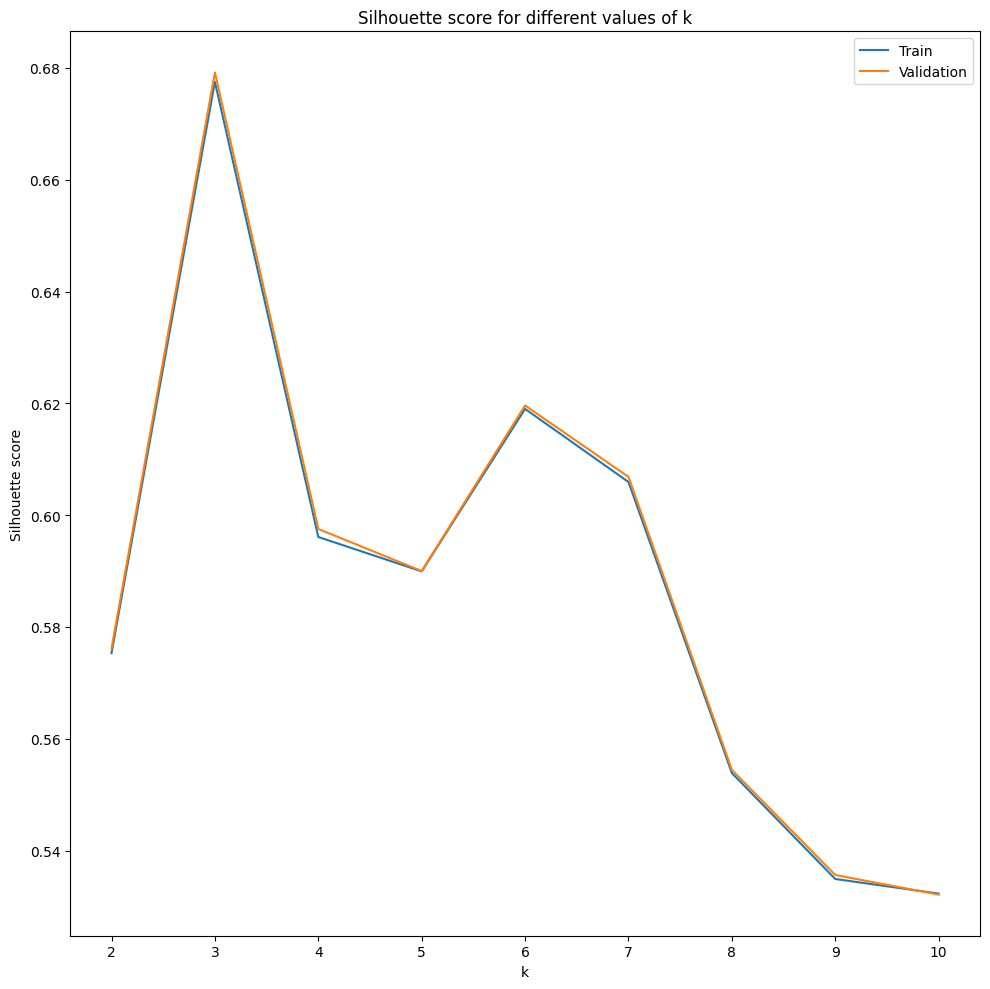

In [41]:
# Plot the silhouette scores
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(2, 11), silhouette_scores["train"], label="Train")
ax.plot(range(2, 11), silhouette_scores["validation"], label="Validation")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette score for different values of k")
ax.legend()

plt.tight_layout()
plt.show()

In [42]:
# Print the best k
best_k = sorted(list(enumerate(silhouette_scores["validation"])), key=lambda t: t[1], reverse=True)[0]
print(f"The best k is {best_k[0] + 2} with a silhouette score of {best_k[1]}")

The best k is 3 with a silhouette score of 0.6791919723074917


In [63]:
location_assembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='locationFeatures')
location_scaler = StandardScaler(inputCol='locationFeatures', outputCol='locationScaledFeatures', withStd=True, withMean=True)
silhouette_scores = {"train": [], "validation": []}

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='locationScaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2, 65):
    kmeans = KMeans(featuresCol='locationScaledFeatures', predictionCol='prediction', k=k, seed=SEED)
    pipeline_clustering = Pipeline(stages=[location_assembler, location_scaler, kmeans])
    
    model = pipeline_clustering.fit(df_train)

    predictions_train = model.transform(df_train)
    predictions_validation = model.transform(df_validation)

    silhouette_train = evaluator.evaluate(predictions_train)
    silhouette_scores["train"].append(silhouette_train)

    silhouette_validation = evaluator.evaluate(predictions_validation)
    silhouette_scores["validation"].append(silhouette_validation)

    print(f"Silhouette score for k = {k} on the train set: {silhouette_train}")
    print(f"Silhouette score for k = {k} on the validation set: {silhouette_validation}")

Silhouette score for k = 2 on the train set: 0.575323091397128
Silhouette score for k = 2 on the validation set: 0.5761597476051895


Silhouette score for k = 3 on the train set: 0.6775069029323885
Silhouette score for k = 3 on the validation set: 0.6791919796496162


Silhouette score for k = 4 on the train set: 0.596089502996792
Silhouette score for k = 4 on the validation set: 0.597532093694236


Silhouette score for k = 5 on the train set: 0.5899409850056078
Silhouette score for k = 5 on the validation set: 0.5900025542079101


Silhouette score for k = 6 on the train set: 0.619002532057835
Silhouette score for k = 6 on the validation set: 0.619620589974036


Silhouette score for k = 7 on the train set: 0.605930491085559
Silhouette score for k = 7 on the validation set: 0.6068464510309839


Silhouette score for k = 8 on the train set: 0.5538660819177905
Silhouette score for k = 8 on the validation set: 0.5544308568482066


Silhouette score for k = 9 on the train set: 0.534910662266048
Silhouette score for k = 9 on the validation set: 0.5356258737657682


Silhouette score for k = 10 on the train set: 0.53229795692959
Silhouette score for k = 10 on the validation set: 0.5321156166957359


Silhouette score for k = 11 on the train set: 0.5354691865456932
Silhouette score for k = 11 on the validation set: 0.5354297302550817


Silhouette score for k = 12 on the train set: 0.4822418934641882
Silhouette score for k = 12 on the validation set: 0.48251475906526303


Silhouette score for k = 13 on the train set: 0.5022452933211228
Silhouette score for k = 13 on the validation set: 0.5019574417612398


Silhouette score for k = 14 on the train set: 0.5510794447996171
Silhouette score for k = 14 on the validation set: 0.5507964355811911


Silhouette score for k = 15 on the train set: 0.5459240882349273
Silhouette score for k = 15 on the validation set: 0.5448995301912982


Silhouette score for k = 16 on the train set: 0.5429471333179832
Silhouette score for k = 16 on the validation set: 0.5439302776560929


Silhouette score for k = 17 on the train set: 0.5467182262501707
Silhouette score for k = 17 on the validation set: 0.547449019868596


Silhouette score for k = 18 on the train set: 0.5204657771434877
Silhouette score for k = 18 on the validation set: 0.5206628621368125


Silhouette score for k = 19 on the train set: 0.5511816151536559
Silhouette score for k = 19 on the validation set: 0.5510194027750417


Silhouette score for k = 20 on the train set: 0.5357500221939112
Silhouette score for k = 20 on the validation set: 0.5365489980225996


Silhouette score for k = 21 on the train set: 0.491310730114946
Silhouette score for k = 21 on the validation set: 0.49221975724737727


Silhouette score for k = 22 on the train set: 0.538962117562682
Silhouette score for k = 22 on the validation set: 0.540078899789431


Silhouette score for k = 23 on the train set: 0.5311776463494345
Silhouette score for k = 23 on the validation set: 0.5316071742011809


Silhouette score for k = 24 on the train set: 0.5101152820495579
Silhouette score for k = 24 on the validation set: 0.5109660648633144


Silhouette score for k = 25 on the train set: 0.55391295350394
Silhouette score for k = 25 on the validation set: 0.5541344334808372


Silhouette score for k = 26 on the train set: 0.5446354035706695
Silhouette score for k = 26 on the validation set: 0.5448537044850545


Silhouette score for k = 27 on the train set: 0.5383855032941726
Silhouette score for k = 27 on the validation set: 0.5373944780359015


Silhouette score for k = 28 on the train set: 0.524231941772265
Silhouette score for k = 28 on the validation set: 0.5248424382355062


Silhouette score for k = 29 on the train set: 0.552166271788586
Silhouette score for k = 29 on the validation set: 0.5528065428154277


Silhouette score for k = 30 on the train set: 0.5531132588726023
Silhouette score for k = 30 on the validation set: 0.5531577058691146


Silhouette score for k = 31 on the train set: 0.5667611523872065
Silhouette score for k = 31 on the validation set: 0.5662394778081808


Silhouette score for k = 32 on the train set: 0.5486824912705
Silhouette score for k = 32 on the validation set: 0.5491728278858958


Silhouette score for k = 33 on the train set: 0.533844008150923
Silhouette score for k = 33 on the validation set: 0.5345879348204754


Silhouette score for k = 34 on the train set: 0.5542648571330768
Silhouette score for k = 34 on the validation set: 0.555514278735407


24/01/20 13:09:27 WARN TaskSetManager: Lost task 17.0 in stage 9516.0 (TID 446685) (node1 executor 3): FetchFailed(BlockManagerId(4, node2, 36167, None), shuffleId=3092, mapIndex=14, mapId=446582, reduceId=17, message=
org.apache.spark.shuffle.FetchFailedException: Block shuffle_3092_446582_17 is corrupted due to NETWORK_ISSUE
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1232)
	at org.apache.spark.storage.BufferReleasingInputStream.tryOrFetchFailedException(ShuffleBlockFetcherIterator.scala:1389)
	at org.apache.spark.storage.BufferReleasingInputStream.read(ShuffleBlockFetcherIterator.scala:1369)
	at java.base/java.io.ObjectInputStream$PeekInputStream.read(ObjectInputStream.java:2893)
	at java.base/java.io.ObjectInputStream$PeekInputStream.readFully(ObjectInputStream.java:2909)
	at java.base/java.io.ObjectInputStream$BlockDataIn

Silhouette score for k = 35 on the train set: 0.5481165020483866
Silhouette score for k = 35 on the validation set: 0.5471290867278666


Silhouette score for k = 36 on the train set: 0.557998528946123
Silhouette score for k = 36 on the validation set: 0.557183532036401


Silhouette score for k = 37 on the train set: 0.5524477989934564
Silhouette score for k = 37 on the validation set: 0.5514393587046047


Silhouette score for k = 38 on the train set: 0.5300228507022396
Silhouette score for k = 38 on the validation set: 0.5302657246002307


Silhouette score for k = 39 on the train set: 0.534379342073006
Silhouette score for k = 39 on the validation set: 0.5345168698557018


Silhouette score for k = 40 on the train set: 0.551952506963126
Silhouette score for k = 40 on the validation set: 0.5512768236709878


Silhouette score for k = 41 on the train set: 0.5298041390548843
Silhouette score for k = 41 on the validation set: 0.5302752595547954


Silhouette score for k = 42 on the train set: 0.5533920053860303
Silhouette score for k = 42 on the validation set: 0.5529493258469854


Silhouette score for k = 43 on the train set: 0.5559304209481352
Silhouette score for k = 43 on the validation set: 0.5551668968322286


Silhouette score for k = 44 on the train set: 0.547552743516592
Silhouette score for k = 44 on the validation set: 0.5476249302203502


Silhouette score for k = 45 on the train set: 0.5534989547798971
Silhouette score for k = 45 on the validation set: 0.5525851763902654


Silhouette score for k = 46 on the train set: 0.5465863536569704
Silhouette score for k = 46 on the validation set: 0.547029623932491


Silhouette score for k = 47 on the train set: 0.5461190515151852
Silhouette score for k = 47 on the validation set: 0.5468092936141561


Silhouette score for k = 48 on the train set: 0.5388103330616247
Silhouette score for k = 48 on the validation set: 0.5386868048073385


Silhouette score for k = 49 on the train set: 0.5399921914070166
Silhouette score for k = 49 on the validation set: 0.5392441084634472


Silhouette score for k = 50 on the train set: 0.5441875752536106
Silhouette score for k = 50 on the validation set: 0.544372474876105


Silhouette score for k = 51 on the train set: 0.5353675892015578
Silhouette score for k = 51 on the validation set: 0.535401192374412


Silhouette score for k = 52 on the train set: 0.541896344242537
Silhouette score for k = 52 on the validation set: 0.5414169009864791


Silhouette score for k = 53 on the train set: 0.5427494356930385
Silhouette score for k = 53 on the validation set: 0.5425150406407471


Silhouette score for k = 54 on the train set: 0.5187043738550349
Silhouette score for k = 54 on the validation set: 0.5180944902137219


Silhouette score for k = 55 on the train set: 0.5557809486288949
Silhouette score for k = 55 on the validation set: 0.5560071240284972


Silhouette score for k = 56 on the train set: 0.548447223628719
Silhouette score for k = 56 on the validation set: 0.5493096477335245


Silhouette score for k = 57 on the train set: 0.5443392856543279
Silhouette score for k = 57 on the validation set: 0.5447442502239704


Silhouette score for k = 58 on the train set: 0.5429774555008055
Silhouette score for k = 58 on the validation set: 0.542562460494946


Silhouette score for k = 59 on the train set: 0.5542563593043363
Silhouette score for k = 59 on the validation set: 0.5533033407883933


Silhouette score for k = 60 on the train set: 0.5510536828860466
Silhouette score for k = 60 on the validation set: 0.5500200229221474


Silhouette score for k = 61 on the train set: 0.5216858130318128
Silhouette score for k = 61 on the validation set: 0.520030835722519


Silhouette score for k = 62 on the train set: 0.5312631563557956
Silhouette score for k = 62 on the validation set: 0.5293757101986458


Silhouette score for k = 63 on the train set: 0.5372795390349833
Silhouette score for k = 63 on the validation set: 0.5377686682095865


Silhouette score for k = 64 on the train set: 0.5437167405163007
Silhouette score for k = 64 on the validation set: 0.5445315861120116


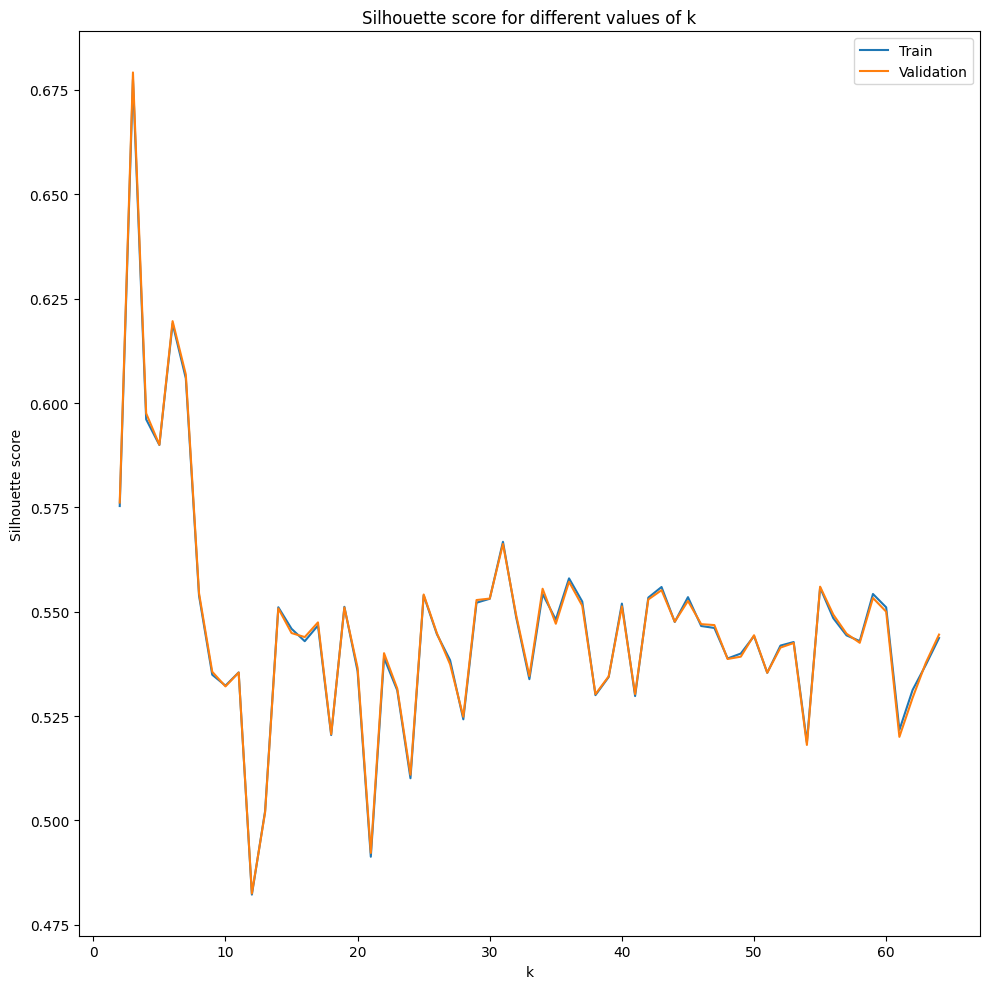

In [64]:
# Plot the silhouette scores
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(2, 65), silhouette_scores["train"], label="Train")
ax.plot(range(2, 65), silhouette_scores["validation"], label="Validation")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette score for different values of k")
ax.legend()

plt.tight_layout()
plt.show()

In [65]:
# Print the best k
best_k = sorted(list(enumerate(silhouette_scores["validation"])), key=lambda t: t[1], reverse=True)[0]
print(f"The best k is {best_k[0] + 2} with a silhouette score of {best_k[1]}")

The best k is 3 with a silhouette score of 0.6791919796496162


In [43]:
kmeans = KMeans(featuresCol='locationScaledFeatures', predictionCol='locationCluster', k=3, seed=SEED)
# pipeline_clustering = Pipeline(stages=[location_assembler, location_scaler, kmeans])

assembler = VectorAssembler(inputCols=['DayOfWeekVec', 'PdDistrictVec', 'YearVec', 'MonthVec', 'HourVec', 'locationCluster'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   year_indexer, month_indexer, hour_indexer,
                   day_of_week_encoder, pd_district_encoder,
                   year_encoder, month_encoder, hour_encoder,
                   location_assembler, location_scaler, kmeans,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline_location_cluster = Pipeline(stages=pipeline_stages)

Logistic regressor

In [45]:
# Train and evaluate the Logistic Regression model
train_evaluate_model(pipeline_location_cluster, lr_model_dict, df_train, df_validation, df_test)

Evaluation of the Logistic Regression model on the train dataset:


f1 score: 0.14550911720463838
precision: 0.1570906061766575
recall: 0.22850882356291938
log loss: 2.55396544684509
Evaluation of the Logistic Regression model on the validation dataset:


f1 score: 0.14599592846106255
precision: 0.15318270959870856
recall: 0.22948107038473348
log loss: 2.5610534477510574
Evaluation of the Logistic Regression model on the test dataset:


f1 score: 0.14616244158806632
precision: 0.15649122662019427
recall: 0.2295881729377301
log loss: 2.558747600712455


Naive Bayes

In [46]:
# Train and evaluate the Naive Bayes model
train_evaluate_model(pipeline_location_cluster, nb_model_dict, df_train, df_validation, df_test)

Evaluation of the Naive Bayes model on the train dataset:


f1 score: 0.1479903811221947
precision: 0.15355775320561696
recall: 0.22519927543111473
log loss: 2.5700608800600473
Evaluation of the Naive Bayes model on the validation dataset:


f1 score: 0.14742487474382274
precision: 0.15274377901245537
recall: 0.2250855784649327
log loss: 2.5768042915082963
Evaluation of the Naive Bayes model on the test dataset:


f1 score: 0.14846824843400566
precision: 0.15377134497447315
recall: 0.225906464077692
log loss: 2.573820729217252


### X and Y features (continuous)

In this approach, the X and Y features are used as they are, without any discretization. However, the features are scaled using StandardScaler, since the features are continuous and they need to be scaled in order to prevent the features with higher values to have a higher impact on the model.

The tested models are a Neural Network and a Random Forest. The first one is made of the first layer of 63 neurons (the number of features), the second layer of 128 neurons, the third layer of 64 neurons and the output layer of 39 neurons (the number of classes). The activation function is sigmoid for the first 3 layers and softmax for the output layer.

The Random Forest is trained using the default hyperparameters, but still it has some memory issues.

The performance of the Neural Network is better than the Random Forest, however it isn't better than the previous models, but it can be improved by tuning the hyperparameters.

In [56]:
# StandardScaler to normalize features
xy_assembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='xyFeatures')
scaler = StandardScaler(inputCol='xyFeatures', outputCol='scaledFeatures', withStd=True, withMean=True)
assembler = VectorAssembler(inputCols=['DayOfWeekVec', 'PdDistrictVec', 'YearVec', 'MonthVec', 'HourVec', 'scaledFeatures'], outputCol='features')

# Define the stages of the pipeline
pipeline_stages = [day_of_week_indexer, pd_district_indexer,
                   year_indexer, month_indexer, hour_indexer,
                   day_of_week_encoder, pd_district_encoder,
                   year_encoder, month_encoder, hour_encoder,
                   xy_assembler, scaler,
                   assembler, label_stringIdx]

# Construct the pipeline
pipeline_xy = Pipeline(stages=pipeline_stages)

transformed_df_train = pipeline_xy.fit(df_train).transform(df_train)

# show the features column of the train dataset transformed by the pipeline and its length
print(f"Number of features: {len(transformed_df_train.select('features').first()[0])}")
transformed_df_train.select('features').show(5, truncate=False)

Number of features: 63


+----------------------------------------------------------------------------------------+
|features                                                                                |
+----------------------------------------------------------------------------------------+
|(63,[5,8,17,36,58,61,62],[1.0,1.0,1.0,1.0,1.0,-0.2797302397954737,0.43061002639052237]) |
|(63,[5,13,22,28,55,61,62],[1.0,1.0,1.0,1.0,1.0,-1.6141455712639923,-1.3851455940041595])|
|(63,[2,8,16,36,56,61,62],[1.0,1.0,1.0,1.0,1.0,-0.6861181069390971,1.159968691081374])   |
|(63,[6,15,28,58,61,62],[1.0,1.0,1.0,1.0,0.7672776375596162,0.34690512210363117])        |
|(63,[3,6,25,29,43,61,62],[1.0,1.0,1.0,1.0,1.0,0.610017254704852,0.5806725574109048])    |
+----------------------------------------------------------------------------------------+
only showing top 5 rows



Neural network

In [58]:
# Train and evaluate the Neural Network model
train_evaluate_model(pipeline_xy, nn_model_dict, df_train, df_validation, df_test)

Evaluation of the Neural Network model on the train dataset:


f1 score: 0.14676951382851877
precision: 0.13842327846022986
recall: 0.2300525198515925
log loss: 2.5847278943088727
Evaluation of the Neural Network model on the validation dataset:


f1 score: 0.14618725433940444
precision: 0.1374393568031421
recall: 0.22957773708930868
log loss: 2.589517910651026
Evaluation of the Neural Network model on the test dataset:


f1 score: 0.14795897834131294
precision: 0.1392243045079176
recall: 0.23143472660747055
log loss: 2.5868814347642606


Random forest

In [59]:
# Train and evaluate the Random Forest model
train_evaluate_model(pipeline_xy, rf_model_dict, df_train, df_validation, df_test)

24/01/20 11:05:05 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB
24/01/20 11:05:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


Evaluation of the Random Forest model on the train dataset:


24/01/20 11:06:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:07:24 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:08:04 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:08:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


f1 score: 0.11010072440855746
precision: 0.09655180679403068
recall: 0.22302898655294326
log loss: 2.6082464991674565
Evaluation of the Random Forest model on the validation dataset:


24/01/20 11:09:23 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:09:41 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:10:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:10:18 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:10:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


f1 score: 0.10960876594162318
precision: 0.09525702501231245
recall: 0.2222708714787731
log loss: 2.612974928494338
Evaluation of the Random Forest model on the test dataset:


24/01/20 11:10:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:10:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:11:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/01/20 11:11:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


f1 score: 0.11074255270270962
precision: 0.09647888652891651
recall: 0.22417389520237996
log loss: 2.6108095888597984
